# Анализ телекоммуникационных данных

## Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники планируют начать предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

**Задача:** обучить на этих данных модель для прогноза оттока клиентов. Необходимо достигнуть метрики ROC-AUC не менее 88%.

**Описание услуг:**
Оператор предоставляет два основных типа услуг:
* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Данные:**
Данные состоят из нескольких файлов, полученных из разных источников:
* `contract_new.csv` — информация о договоре;
* `personal_new.csv` — персональные данные клиента;
* `internet_new.csv` — информация об интернет-услугах;
* `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

**Тип задачи:** классификация


## Описание данных

**Файл `contract_new.csv`:**
* `customerID` — идентификатор абонента;
* `BeginDate` — дата начала действия договора;
* `EndDate` — дата окончания действия договора;
* `Type` — тип оплаты: раз в год-два или ежемесячно;
* `PaperlessBilling` — электронный расчётный лист;
* `PaymentMethod` — тип платежа;
* `MonthlyCharges` — расходы за месяц;
* `TotalCharges` — общие расходы абонента.

**Файл `personal_new.csv`:**
* `customerID` — идентификатор пользователя;
* `gender` — пол;
* `SeniorCitizen` — является ли абонент пенсионером;
* `Partner` — есть ли у абонента супруг или супруга;
* `Dependents` — есть ли у абонента дети.

**Файл `internet_new.csv`:**
* `customerID` — идентификатор пользователя;
* `InternetService` — тип подключения;
* `OnlineSecurity` — блокировка опасных сайтов;
* `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
* `DeviceProtection` — антивирус;
* `TechSupport` — выделенная линия технической поддержки;
* `StreamingTV` — стриминговое телевидение;
* `StreamingMovies` — каталог фильмов.

**Файл `phone_new.csv`:**
* `customerID` — идентификатор пользователя;
* `MultipleLines` — подключение телефона к нескольким линиям одновременно.


## План работы

* Загрузка данных
_Загрузка данных и первичный осмотр._
* Исследовательский анализ и предобработка данных
_Исследовательский анализ каждого датафрейма и предобработка. Выводы о пригодности для обучения по имеющимся признакам._
* Объединение данных
_Объединение выбранных для обучения признаков в один датафрейм._
* Исследовательский анализ и предобработка данных объединённого датафрейма
_Исследовательский анализ объединённого датафрейма, визуализация распределения признаков и предобработка, создание новых признаков и корреляционный анализ._
* Подготовка данных
_Подготовка данных для обучения модели. Кодирование, масштабирование, выделение выборок для обучения, кроссвалидации и тестировния._
* Обучение моделей машинного обучения
_Обучение не менее двух типов моделей и подбор лучших гиперпараметров._
* Выбор лучшей модели
_Выбор лучшей модели и проверка на тестовой выборке._
* Общие выводы и рекомендации заказчику
_Выводы по полученным результатам и рекомендации для бизнеса._

## Импорты, настройки и установки

Импорты:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from scipy.stats import randint
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

Настройки:

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)
random_state = 160224
np.random.seed(random_state)

## Загрузка данных
**Загрузка данных и первичный осмотр.**

Загрузка данных:

In [3]:
try:
    df_contract_original = pd.read_csv('/datasets/contract_new.csv', index_col='customerID')
    df_personal_original = pd.read_csv('/datasets/personal_new.csv', index_col='customerID')
    df_internet_original = pd.read_csv('/datasets/internet_new.csv', index_col='customerID')
    df_phone_original = pd.read_csv('/datasets/phone_new.csv', index_col='customerID')
    display('Данные из практикума загружены.')
except:
    df_contract_original = pd.read_csv('datasets/contract_new.csv', index_col='customerID')
    df_personal_original = pd.read_csv('datasets/personal_new.csv', index_col='customerID')
    df_internet_original = pd.read_csv('datasets/internet_new.csv', index_col='customerID')
    df_phone_original = pd.read_csv('datasets/phone_new.csv', index_col='customerID')
    display('Локальные данные загружены.')

df_contract_original.name = 'df_contract'
df_personal_original.name = 'df_personal'
df_internet_original.name = 'df_internet'
df_phone_original.name = 'df_phone'

'Локальные данные загружены.'

Первичный осмотр данных:

In [4]:
df_list = [df_contract_original,
           df_personal_original,
           df_internet_original,
           df_phone_original]

for df in df_list:
    display('================================================================')
    display(f'Информация по {df.name}: {df.shape}')
    display('Голова:', df.head())
    display('Хвост:', df.tail())
    display('Инфо:')
    df.info()
    display('Статистики:')
    display(df.describe(include='all'))

'================================================================'

'Информация по df_contract: (7043, 7)'

'Голова:'

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


'Хвост:'

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6
8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8
3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,7251.82


'Инфо:'

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


'Статистики:'

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043.00,7043
unique,77,67,3,2,4,NaN,6658
top,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,64.76,NaN
std,NaN,NaN,NaN,NaN,NaN,30.09,NaN
min,NaN,NaN,NaN,NaN,NaN,18.25,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.50,NaN
50%,NaN,NaN,NaN,NaN,NaN,70.35,NaN
75%,NaN,NaN,NaN,NaN,NaN,89.85,NaN


'================================================================'

'Информация по df_personal: (7043, 4)'

'Голова:'

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


'Хвост:'

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
6840-RESVB,Male,0,Yes,Yes
2234-XADUH,Female,0,Yes,Yes
4801-JZAZL,Female,0,Yes,Yes
8361-LTMKD,Male,1,Yes,No
3186-AJIEK,Male,0,No,No


'Инфо:'

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


'Статистики:'

,gender,SeniorCitizen,Partner,Dependents
count,7043,7043.00,7043,7043
unique,2,NaN,2,2
top,Male,NaN,No,No
freq,3555,NaN,3641,4933
mean,NaN,0.16,NaN,NaN
std,NaN,0.37,NaN,NaN
min,NaN,0.00,NaN,NaN
25%,NaN,0.00,NaN,NaN
50%,NaN,0.00,NaN,NaN
75%,NaN,0.00,NaN,NaN


'================================================================'

'Информация по df_internet: (5517, 7)'

'Голова:'

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


'Хвост:'

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
4801-JZAZL,DSL,Yes,No,No,No,No,No
8361-LTMKD,Fiber optic,No,No,No,No,No,No
3186-AJIEK,Fiber optic,Yes,No,Yes,Yes,Yes,Yes


'Инфо:'

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


'Статистики:'

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


'================================================================'

'Информация по df_phone: (6361, 1)'

'Голова:'

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


'Хвост:'

,MultipleLines
customerID,
2569-WGERO,No
6840-RESVB,Yes
2234-XADUH,Yes
8361-LTMKD,Yes
3186-AJIEK,No


'Инфо:'

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


'Статистики:'

,MultipleLines
count,6361
unique,2
top,No
freq,3390


Посмотрим нет ли прямых дубликатов и повторяющихся индексов в датафреймах:

In [5]:
for df in df_list:
    display('================================================================')
    display(df.name)
    display('Прямые дубли:', df.duplicated().sum())
    display('Дубли в индексах:', df.index.duplicated().sum())

'================================================================'

'df_contract'

'Прямые дубли:'

37

'Дубли в индексах:'

0

'================================================================'

'df_personal'

'Прямые дубли:'

7027

'Дубли в индексах:'

0

'================================================================'

'df_internet'

'Прямые дубли:'

5389

'Дубли в индексах:'

0

'================================================================'

'df_phone'

'Прямые дубли:'

6359

'Дубли в индексах:'

0

Взглянем на столбец EndDate повнимательнее:

In [6]:
df_contract_original['EndDate'].value_counts()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2015-04-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: EndDate, Length: 67, dtype: int64

### Выводы
* Наиболее полные данные содержатся в первых двух датафреймах, количество уникальных пользователей составляет 7043 штук.
* Пропусков в данных нет.
* Дубликатов по индексу нет. Есть большое количество прямых дублей (без учёта id), что вызывает определенные опасения в корректности собранных данных. В df_prsonal из 7043 записей 7027 дублируются (в этом датафрейме всего 4 столбца, но даже при таком количестве столбцов количество дублей аномально). Аналогичная ситуация с df_internet. Большое количество дублей в df_phone менее подозрительно, т.к. в датафрейме всего один столбец. **Необходимо прокоммуницировать с клиентом по поводу корректности предоставленных таблиц.**
* Не все типы данных определились корректно:
    * BeginDate - необходимо преобразовать в datetime.
    * EndDate - необходимо преобразовать в datetime с заменой No на Nan.
    * TotalCharges - необходимо преобразовать во float.
* Данные с датами, судя по всему, округлены до месяца. Вероятно, это не лучшим образом скажется на качестве обучения модели. **Необходимо прокоммуницировать с клиентом по поводу возможности получения более точных данных.**

## Исследовательский анализ и предобработка данных
**Исследовательский анализ каждого датафрейма и предобработка. Выводы о пригодности для обучения по имеющимся признакам.**


Создадим рабочие копии датафреймов:

In [7]:
df_contract = df_contract_original.copy()
df_personal = df_personal_original.copy()
df_internet = df_internet_original.copy()
df_phone = df_phone_original.copy()

df_contract.name = 'df_contract'
df_personal.name = 'df_personal'
df_internet.name = 'df_internet'
df_phone.name = 'df_phone'

Приведем названия столбцов к snake case:

In [8]:
df_contract.columns = ['begin_date',
                       'end_date',
                       'type',
                       'paperless_billing',
                       'payment_method',
                       'monthly_charges',
                       'total_charges']
df_personal.columns = ['gender',
                       'senior_citizen',
                       'partner',
                       'dependents']
df_internet.columns = ['internet_service',
                       'online_security',
                       'online_backup',
                       'device_protection',
                       'tech_support',
                       'streaming_tv',
                       'streaming_movies']
df_phone.columns = ['multiple_lines']

Преобразуем типы данных, которые неверно определились:

In [9]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format='%Y-%m-%d')

In [10]:
lambda_func = lambda x: float('nan') if (x == 'No') else x
df_contract['end_date'] = df_contract['end_date'].apply(lambda_func)
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], format='%Y-%m-%d')

Попробуем выяснить в чем проблема с total_charges:

In [11]:
df_contract['total_charges'].value_counts()

           11
20.45       6
101.0       5
1007.5      4
19.65       4
           ..
6310.5      1
1673.25     1
384.75      1
970.11      1
750.12      1
Name: total_charges, Length: 6658, dtype: int64

Посмотрим на строки с пустыми значениями:

In [12]:
empty_cell_value = df_contract['total_charges'].value_counts().index[0]
df_contract[df_contract['total_charges'] == empty_cell_value]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customerID,,,,,,,
4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,


Видим, что все строки по клиентам, которые были зарегистрированы в последний день, другими словами - это скорее всего клиенты в процессе создания их карточек. Вероятность того, что их total_charges ненулевая - очень мала. Можем смело заполнить эти значения нулями и привести тип столбца к float64:

In [13]:
lambda_func = lambda x: 0 if (x == empty_cell_value) else x
df_contract['total_charges'] = df_contract['total_charges'].apply(lambda_func)
df_contract['total_charges'] = df_contract['total_charges'].astype('float64')
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 698.2+ KB


Данные готовы к eda.

Напишем функцию для визуализации:

In [14]:
def visualize_df(df: pd.DataFrame, bins=100, pieces=10):
    display(f'Визуализация для {df.name}:')
    for column in df.columns:
        # Гистограмма с боксплотом.
        if df[column].dtype in ['float64']:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 6), gridspec_kw={'height_ratios': [3, 1]})
            df.hist(column=column, bins=bins, ax=ax1)
            df.boxplot(column=column, vert=False, ax=ax2)
            ax1.set_title(f'Гистограмма и боксплот для {column}', fontsize=20, weight='bold')
            ax1.set_ylabel('Частота', fontsize=15)
            ax1.tick_params(axis='both', labelsize=15)
            ax2.set_xlabel('Значение', fontsize=15)
            ax2.tick_params(axis='both', labelsize=0)
            plt.show()
            display(f'Количество уникальных значений в столбце {column}: {df[column].value_counts().shape[0]}')
        # Только гистограмма
        elif df[column].dtype in ['datetime64[ns]']:
            fig, ax = plt.subplots(figsize = (20, 6))
            df.hist(column=column, bins=bins, ax=ax)
            ax.set_title(f'Гистограмма и боксплот для {column}', fontsize=20, weight='bold')
            ax.set_ylabel('Частота', fontsize=15)
            ax.tick_params(axis='both', labelsize=15)
            plt.show()
            display(f'Количество уникальных значений в столбце {column}: {df[column].value_counts().shape[0]}')
        # Пироги
        else:
            num_or_pieces = pieces
            vc_for_data = df[column].value_counts()

            # Группировка в other при необходимости
            if vc_for_data.shape[0] > num_or_pieces:
                data_to_display = vc_for_data.iloc[:num_or_pieces-1]
                data_to_display['Other categories'] = vc_for_data.iloc[num_or_pieces-1:].sum()
            else:
                data_to_display = vc_for_data

            fig, ax = plt.subplots(figsize = (20, 6))
            data_to_display.plot(kind='pie', ax=ax, autopct='%.2f')
            ax.set_title(f'Распределение значений для {column}', fontsize=20, weight='bold')
            ax.set_ylabel('', fontsize=15)
            ax.tick_params(axis='both', labelsize=15)
            plt.show()
            display(f'Количество уникальных значений в столбце {column}: {df[column].value_counts().shape[0]}')
            display(f'Количество пропусков в столбце {column}: {df[column].isna().sum():.2f} ({df[column].isna().mean():.2%})')

Сделаем визуализацию:

'Визуализация для df_contract:'

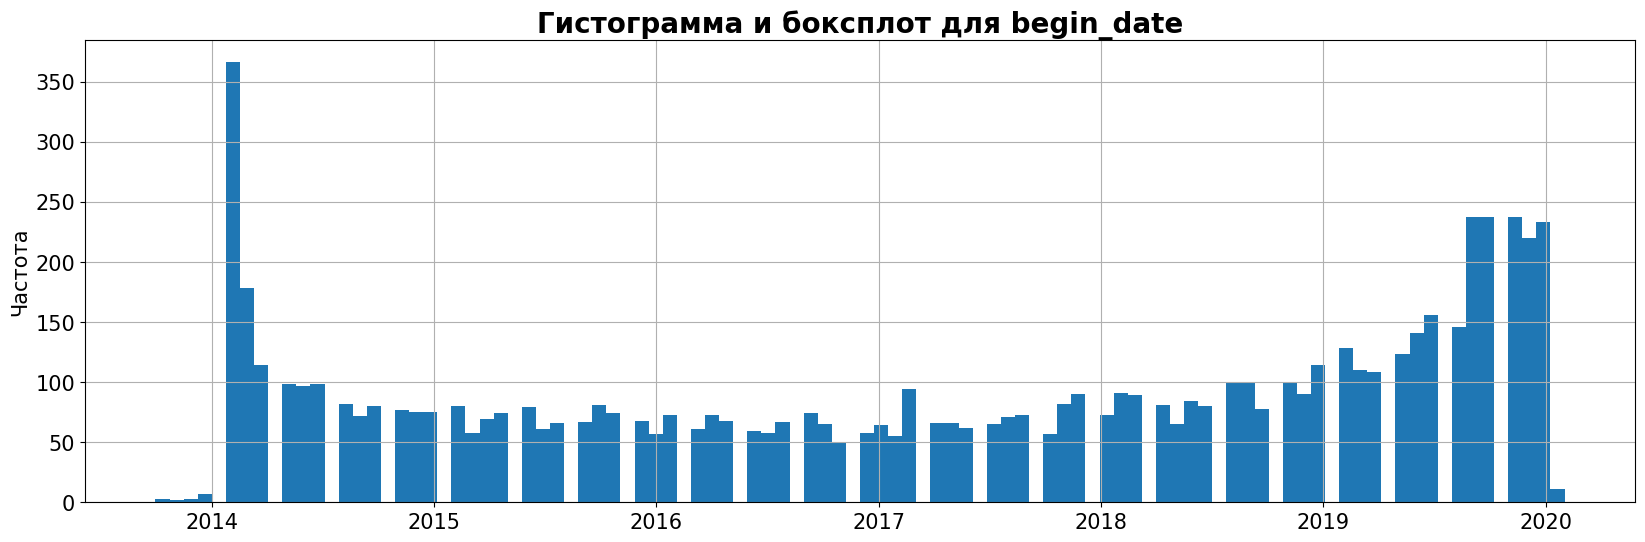

'Количество уникальных значений в столбце begin_date: 77'

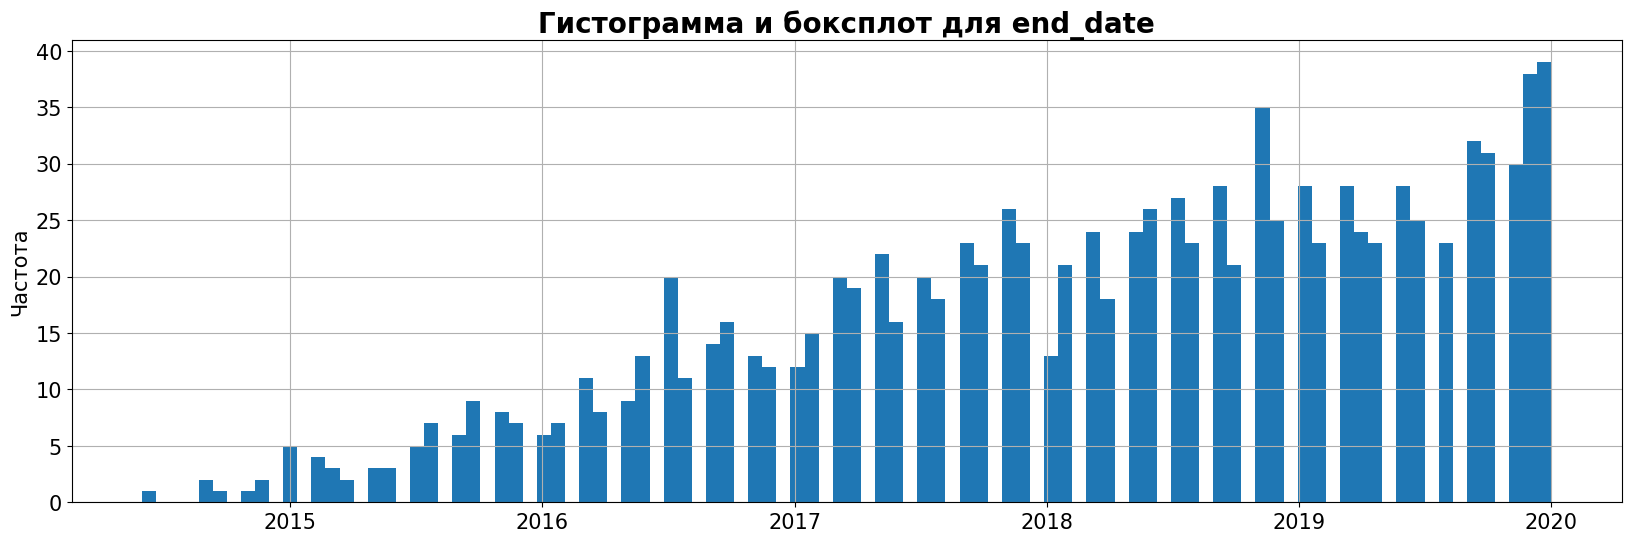

'Количество уникальных значений в столбце end_date: 66'

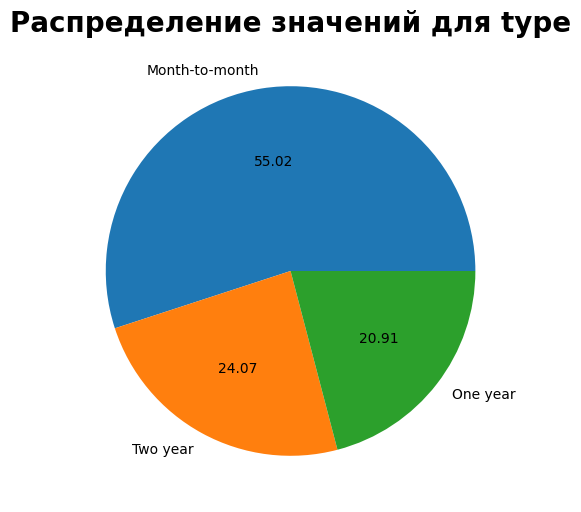

'Количество уникальных значений в столбце type: 3'

'Количество пропусков в столбце type: 0.00 (0.00%)'

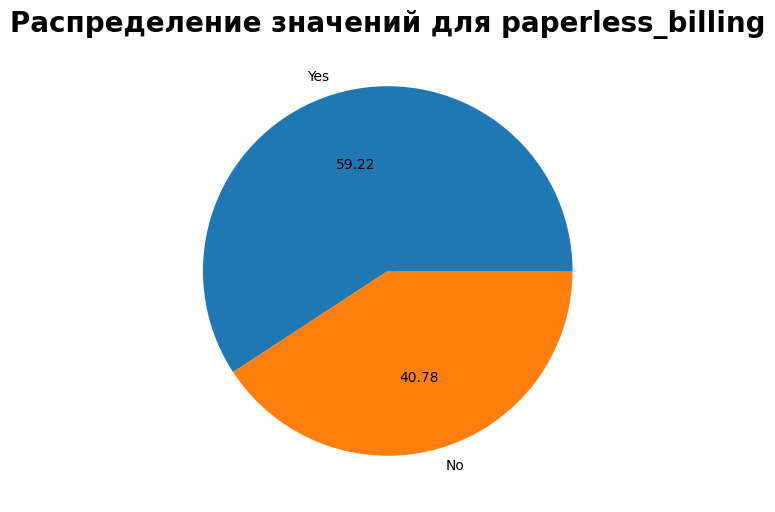

'Количество уникальных значений в столбце paperless_billing: 2'

'Количество пропусков в столбце paperless_billing: 0.00 (0.00%)'

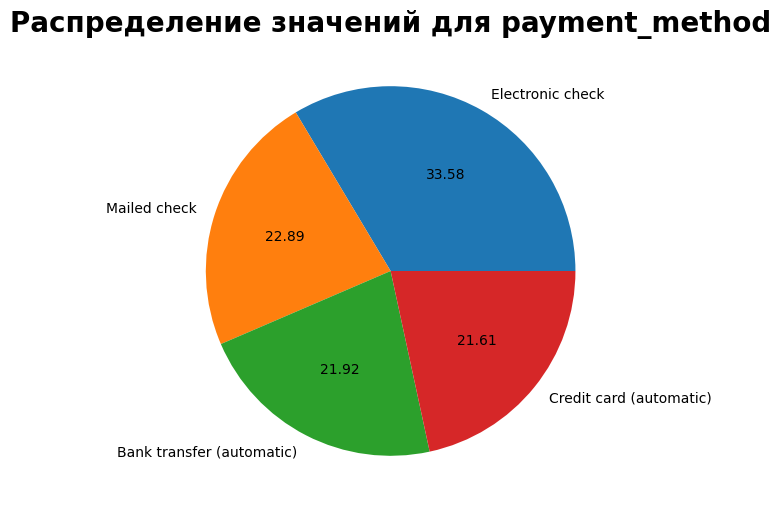

'Количество уникальных значений в столбце payment_method: 4'

'Количество пропусков в столбце payment_method: 0.00 (0.00%)'

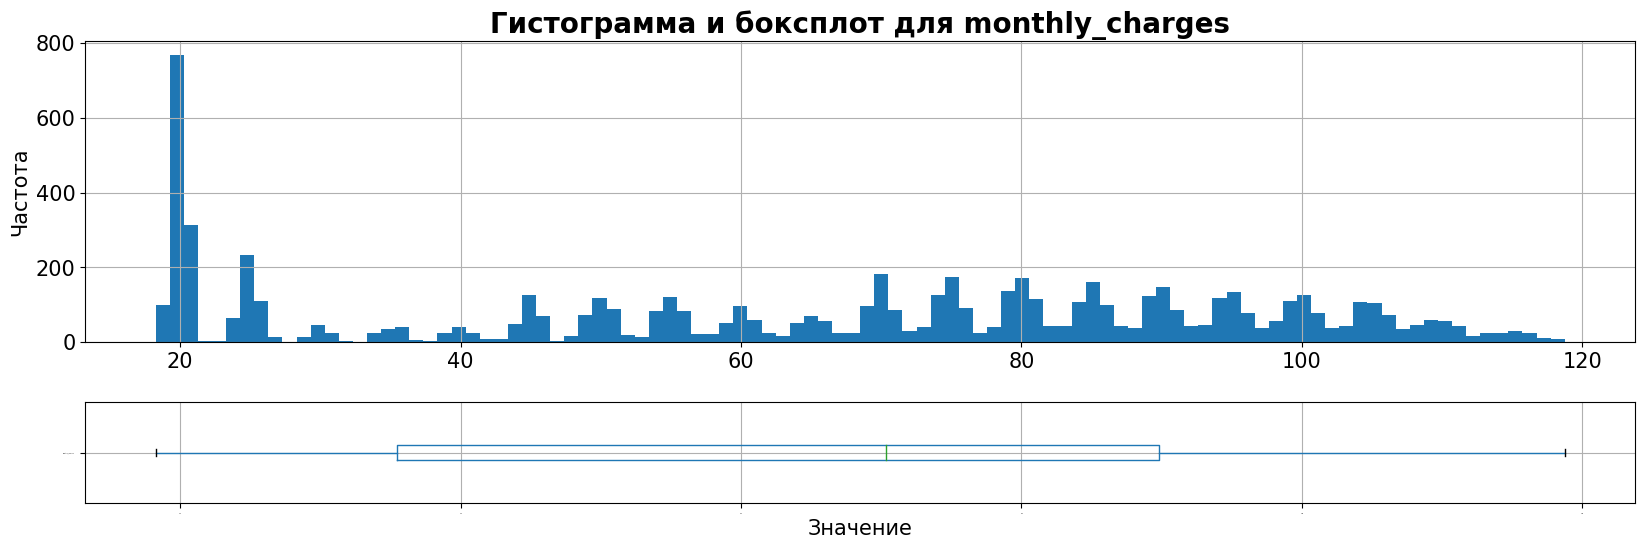

'Количество уникальных значений в столбце monthly_charges: 1585'

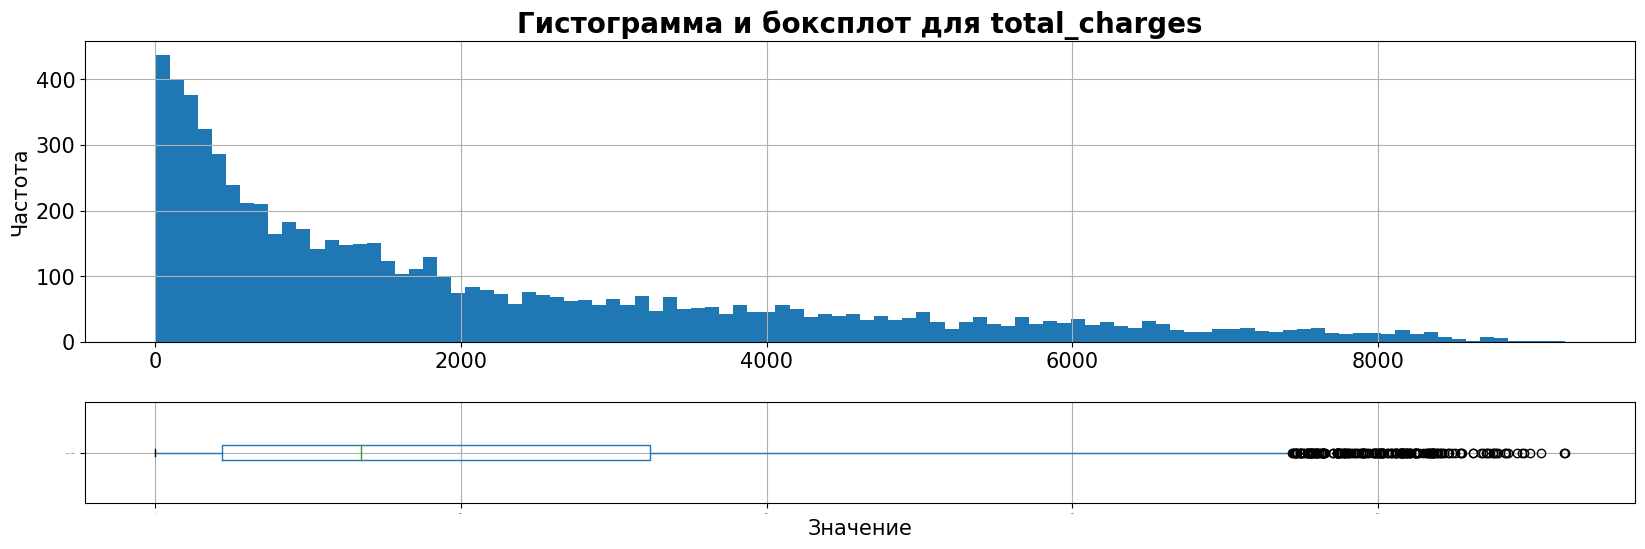

'Количество уникальных значений в столбце total_charges: 6658'

'Визуализация для df_personal:'

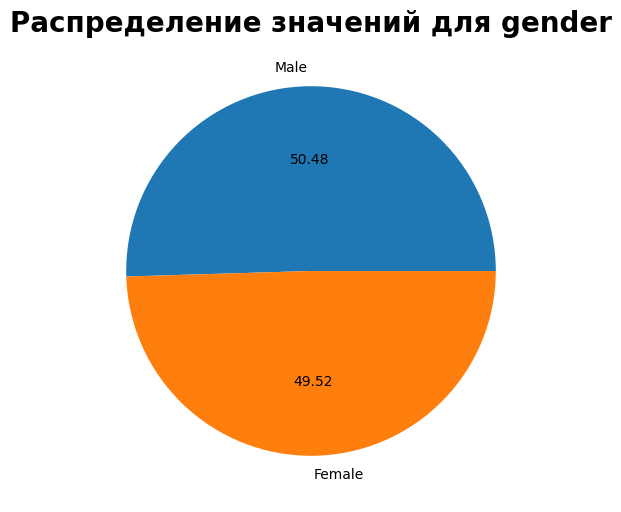

'Количество уникальных значений в столбце gender: 2'

'Количество пропусков в столбце gender: 0.00 (0.00%)'

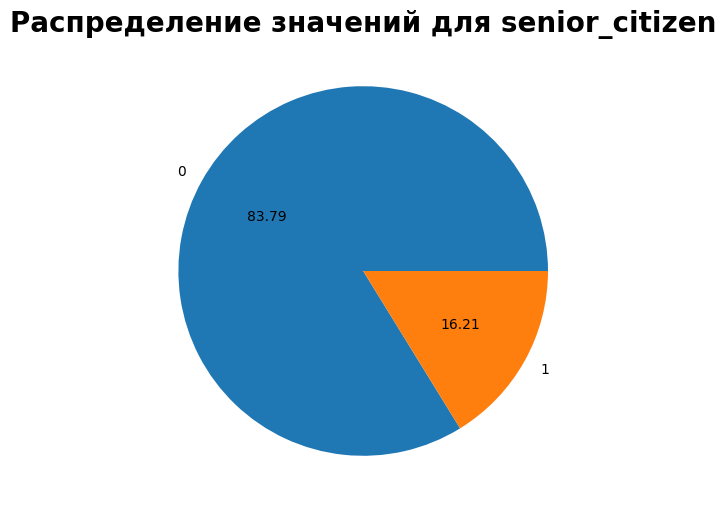

'Количество уникальных значений в столбце senior_citizen: 2'

'Количество пропусков в столбце senior_citizen: 0.00 (0.00%)'

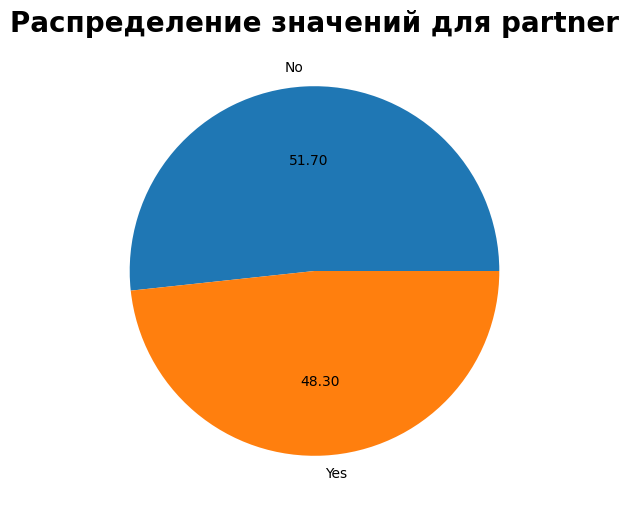

'Количество уникальных значений в столбце partner: 2'

'Количество пропусков в столбце partner: 0.00 (0.00%)'

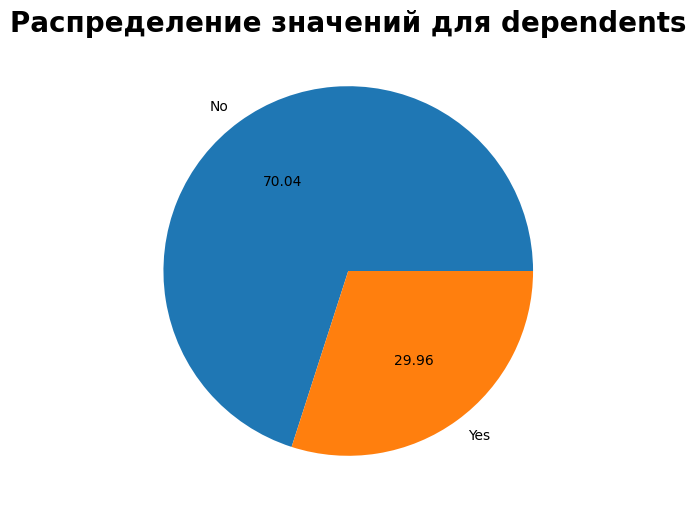

'Количество уникальных значений в столбце dependents: 2'

'Количество пропусков в столбце dependents: 0.00 (0.00%)'

'Визуализация для df_internet:'

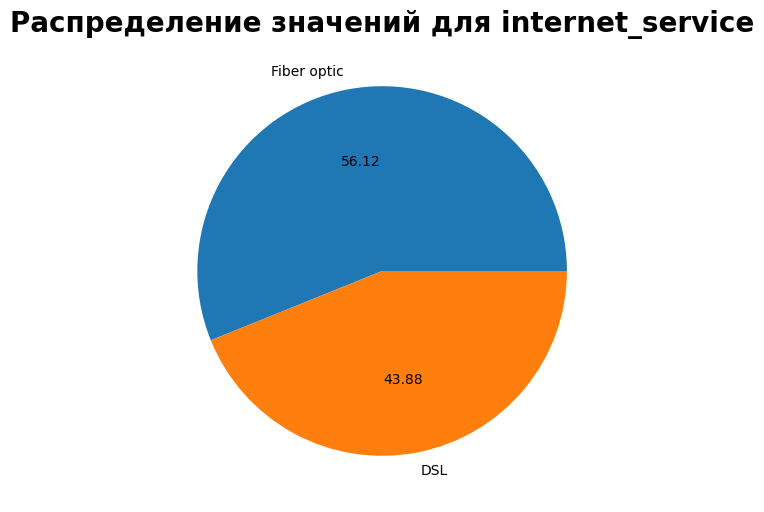

'Количество уникальных значений в столбце internet_service: 2'

'Количество пропусков в столбце internet_service: 0.00 (0.00%)'

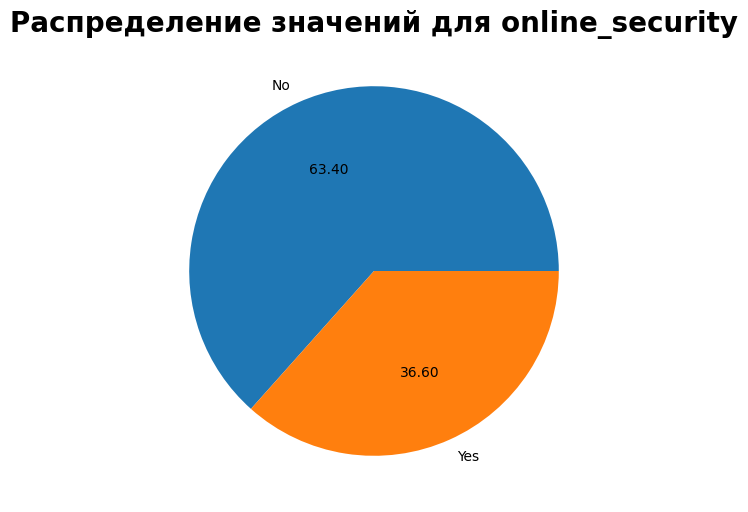

'Количество уникальных значений в столбце online_security: 2'

'Количество пропусков в столбце online_security: 0.00 (0.00%)'

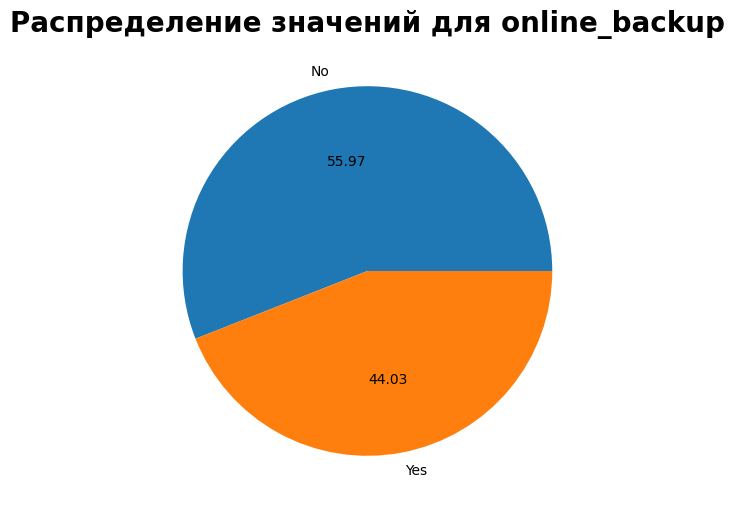

'Количество уникальных значений в столбце online_backup: 2'

'Количество пропусков в столбце online_backup: 0.00 (0.00%)'

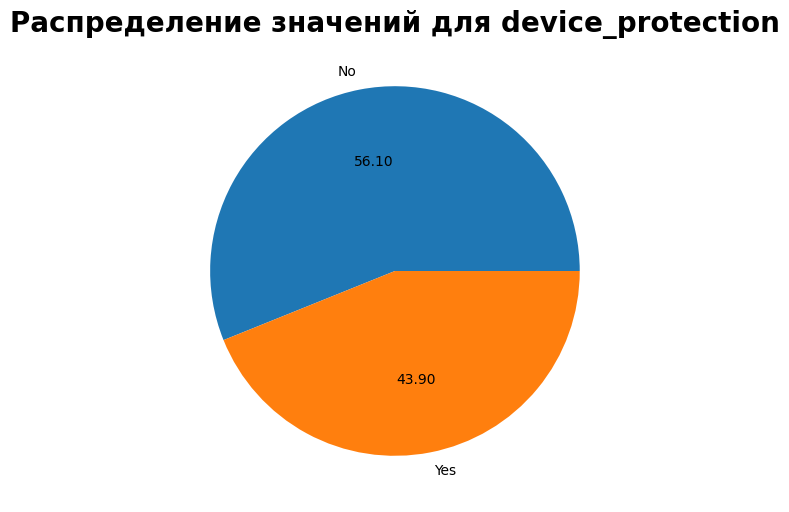

'Количество уникальных значений в столбце device_protection: 2'

'Количество пропусков в столбце device_protection: 0.00 (0.00%)'

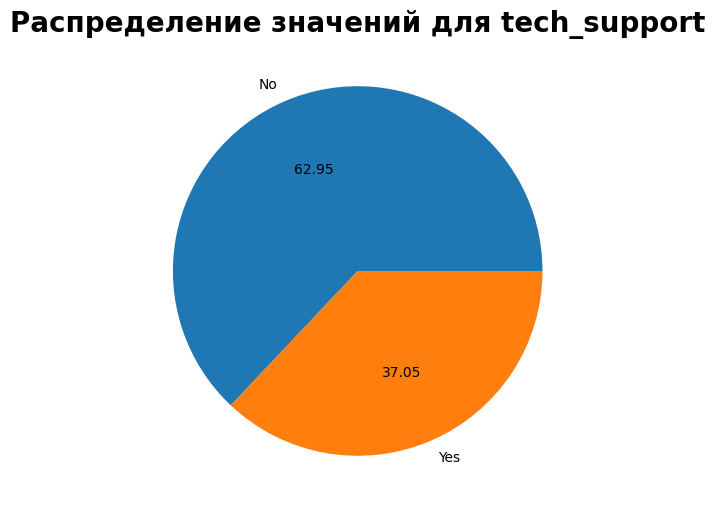

'Количество уникальных значений в столбце tech_support: 2'

'Количество пропусков в столбце tech_support: 0.00 (0.00%)'

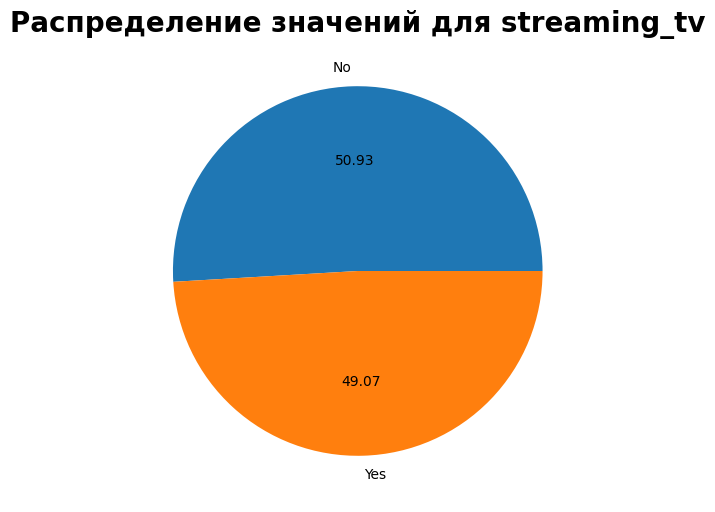

'Количество уникальных значений в столбце streaming_tv: 2'

'Количество пропусков в столбце streaming_tv: 0.00 (0.00%)'

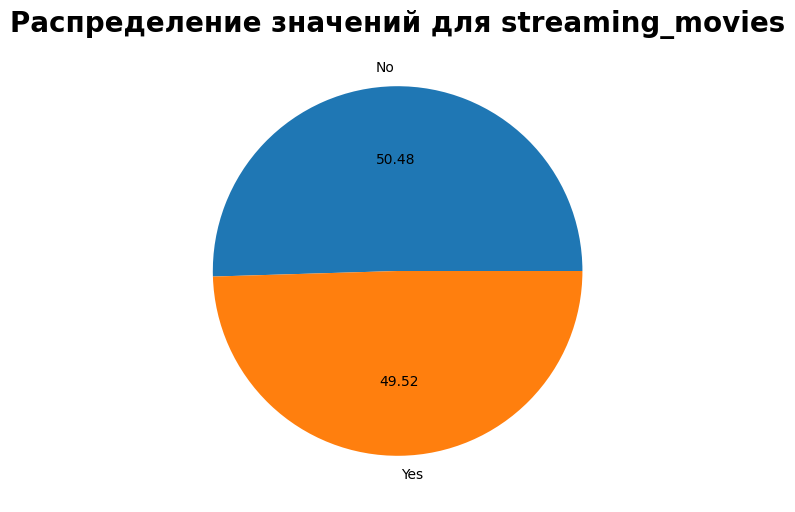

'Количество уникальных значений в столбце streaming_movies: 2'

'Количество пропусков в столбце streaming_movies: 0.00 (0.00%)'

'Визуализация для df_phone:'

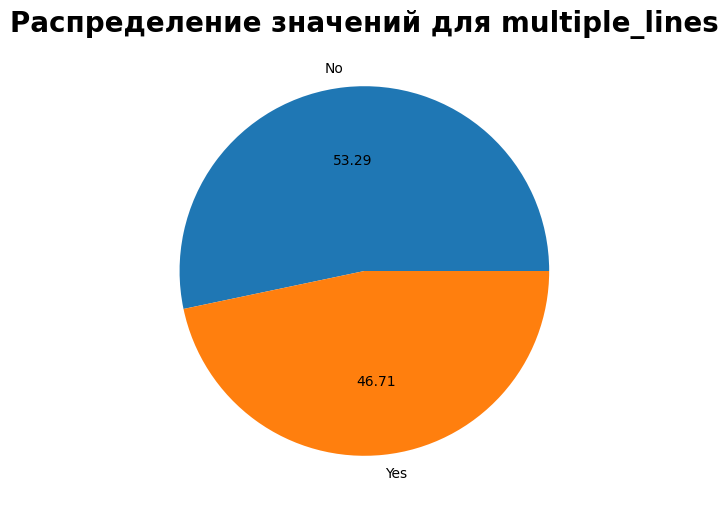

'Количество уникальных значений в столбце multiple_lines: 2'

'Количество пропусков в столбце multiple_lines: 0.00 (0.00%)'

In [15]:
df_list = [df_contract,
           df_personal,
           df_internet,
           df_phone]

for df in df_list:
    visualize_df(df)

Посмотрим на левую часть гистограммы для begin_date:

'Визуализация для begin_date:'

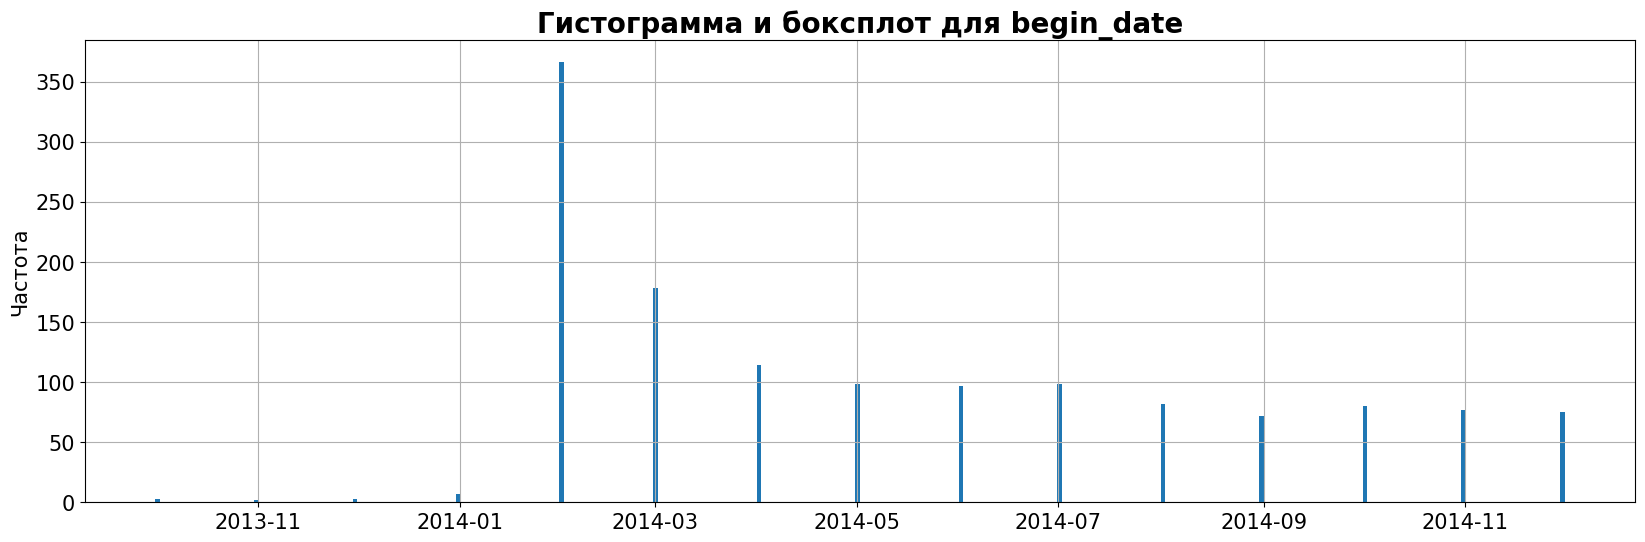

'Количество уникальных значений в столбце begin_date: 15'

In [16]:
to_visualize = pd.DataFrame(df_contract[df_contract['begin_date'] < '2015-01-01']['begin_date'])
to_visualize.name = 'begin_date'
visualize_df(to_visualize, bins=300)

Посмотрим на пользователей до 14 года:

In [17]:
df_contract[df_contract['begin_date'] < '2014-01-01']

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customerID,,,,,,,
2834-JRTUA,2013-11-01,NaT,Two year,Yes,Electronic check,108.05,8184.79
7317-GGVPB,2013-11-01,NaT,Two year,Yes,Credit card (automatic),108.60,8145.00
0917-EZOLA,2013-10-01,NaT,Two year,Yes,Bank transfer (automatic),104.15,7915.40
8580-QVLOC,2013-10-01,NaT,Two year,No,Credit card (automatic),92.45,7026.20
2889-FPWRM,2013-10-01,NaT,One year,Yes,Bank transfer (automatic),117.80,9221.38
3512-IZIKN,2013-12-01,2017-10-01,Two year,No,Credit card (automatic),65.30,3003.80
1555-DJEQW,2013-12-01,2014-11-01,Two year,Yes,Bank transfer (automatic),114.20,1281.32
2530-ENDWQ,2013-12-01,NaT,Two year,Yes,Bank transfer (automatic),93.70,6933.80


По большому счёту ничего необычного. С чем же связано резкое увеличение количества пользователей в феврале 2014 года? Вероятно была какая-то масштабная компания по привлечению клиентов с резким снижением стоимости обслуживания? Посмотрим на monthly_charges:

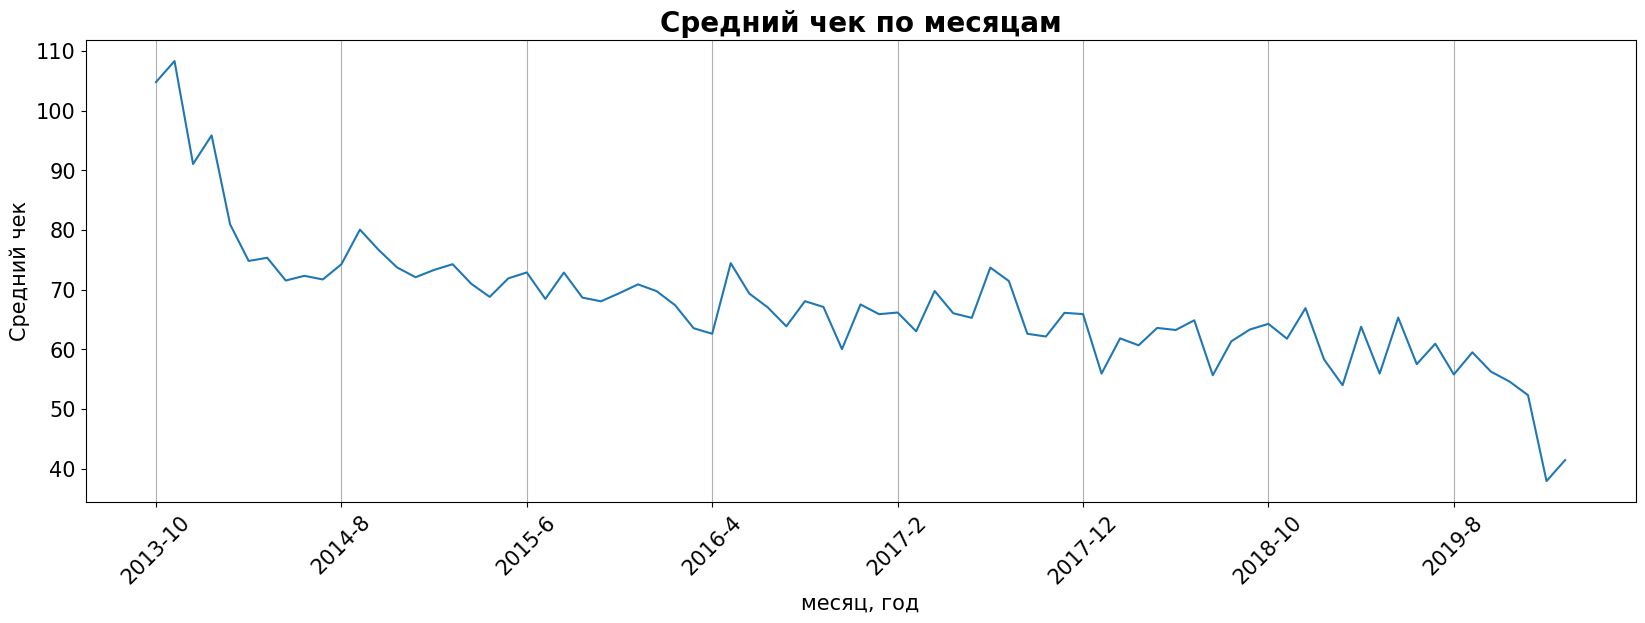

year  month
2013  10      104.80
      11      108.32
      12       91.07
2014  1        95.86
      2        80.93
      3        74.81
Name: monthly_charges, dtype: float64

In [18]:
df_contract['year'] = pd.DatetimeIndex(df_contract['begin_date']).year
df_contract['month'] = pd.DatetimeIndex(df_contract['begin_date']).month
to_visualize = df_contract.groupby(['year', 'month']).mean()['monthly_charges']
to_visualize.index = [str(x[0]) + '-' + str(x[1]) for x in to_visualize.index]

# Посмотрим на графике
fig, ax = plt.subplots(figsize = (20, 6))
to_visualize.plot(ax=ax)
ax.set_title(f'Средний чек по месяцам', fontsize=20, weight='bold')
ax.set_xlabel('месяц, год', fontsize=15)
ax.set_ylabel('Средний чек', fontsize=15)
ax.tick_params(axis='both', labelsize=15)
plt.xticks(rotation=45)
plt.grid(visible=True, which='both', axis='x')
plt.show()

# Посмотрим цифрах
display(df_contract.groupby(['year', 'month']).mean()['monthly_charges'].iloc[:6])
df_contract.drop(columns=['year', 'month'], inplace=True)

**Необходимо подтвердить причины этого пика у клиента.**

Посмотрим на end_date:

In [19]:
# Период не выходит за рамки begin_date
display(df_contract['end_date'].value_counts().sort_index())
# begin_date всегда раньше end_date
df_contract[df_contract['begin_date'] > df_contract['end_date']].shape[0]

2014-06-01     1
2014-09-01     2
2014-10-01     1
2014-11-01     1
2014-12-01     2
              ..
2019-09-01    32
2019-10-01    31
2019-11-01    30
2019-12-01    38
2020-01-01    39
Name: end_date, Length: 66, dtype: int64

0

Здесь всё хорошо.

Взглянем чуть подробнее на monthly_charges и total_charges:

In [20]:
df_contract[['monthly_charges', 'total_charges']].describe()

,monthly_charges,total_charges
count,7043.00,7043.00
mean,64.76,2115.31
std,30.09,2112.74
min,18.25,0.00
25%,35.50,436.75
50%,70.35,1343.35
75%,89.85,3236.69
max,118.75,9221.38


Всё выглядит нормально.

Посмотрим на пик в районе 20 баксов по monthly_charges:

'Визуализация для monthly_charges:'

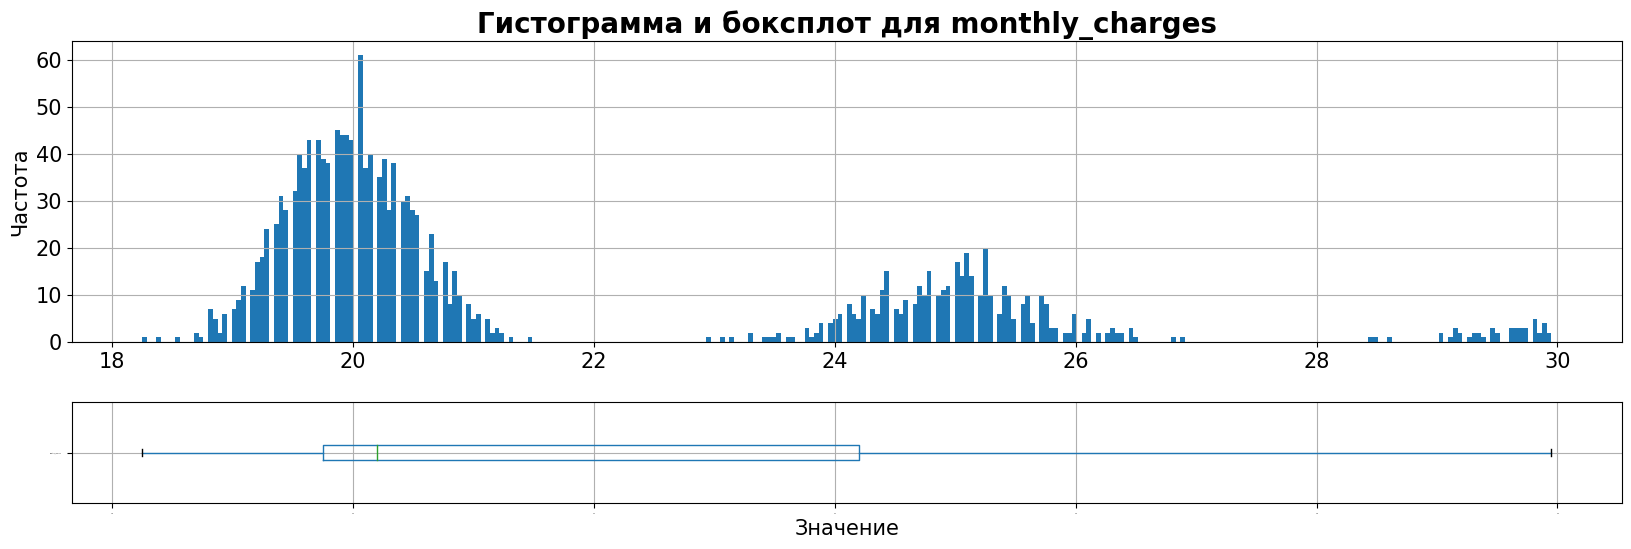

'Количество уникальных значений в столбце monthly_charges: 145'

In [21]:
to_visualize = pd.DataFrame(df_contract[df_contract['monthly_charges'] < 30]['monthly_charges'])
to_visualize.name = 'monthly_charges'
visualize_df(to_visualize, bins=300)

Ничего необычного, видим пики в районе 20, 25 и.т.д. Это связано с желанием сделать ценник для клиента более простым и округлить его до простой понятной величины. Вероятно, есть тариф в районе 20 долларов, который по естественным причинам пользуется особой популярностью. Значения вокруг округленных, вероятнее всего связаны либо с какими-то скидками, либо с допуслугами относительно базовой величины.

### Выводы
* Данные по клиентам представлены в период с октября 2013 года по февраль 2020 года.
* Количество клиентов имеет пик в районе февраля 2014 года. **Необходимо перепроверить у клиента, что он связан с резким снижением цены оказания услуг.** Так же есть рост количества клиентов к концу рассматриваемого периода, но он не выглядит аномально.
* Все пироги выглядят разумно и говорят сами за себя.
* Данные по платежам так же не показывают каких-то необъяснимых аномалий, боксплоты не показывают явных выбросов, гистограммы не показывают распределения, которы нельзя было бы объяснить.


**Гипотеза по применимости данных к обучению:**
* Данные скорее всего пригодны к построению модели под поставленные задачи. Они относительно чистые.
* Таргет будет необходимо сформировать на основе столбца end_date.
* Категориальные столбцы с 2 значаениями легко переведутся в OI. Остальные значения можно закодировать one-hot или target encoding. Недостающие данные из-за несоответствия размеров исходных датафреймов можно будет закодировать в отдельную категорию. Количество признаков будет в итоге вполне адекватным.

**Утечка данных:**
* Важным вопросом касательно данной задачи является утечка данных. Напрямую или косвенно утечка может произойти через столбцы begin_date, end_date и total_charges. end_date напрямую содержит таргет, а ранний begin_date вместе с низким total_charges - явно указывает, что клиент услугами пользовался недолго.
* В связи с этим фактом необходимо конкретизировать условия задачи в формулировке "предсказывать, разорвёт ли абонент договор" либо до формулировки "предсказывать, разорвёт ли абонент договор в обозримом будущем", либо в течение конкретного периода (напр. полгода или месяц), либо в формулировке "в самое ближайшее время".
* Так как в формулировке задачи есть такая характеристика клиента как "планирует отказаться от услуг связи", примем за базовую установку подход "предсказывать, разорвёт ли абонент договор в самое ближайшее время". В дополнение к этим рассуждениям стоит добавить, что не очень рационально раздавать промокоды, улучшающие условия договора (и уменьшающие финансовую отдачу) для клиента, который возможно задумается об уходе через месяц или полгода - не очень разумно. Таким образом, после формирования таргета мы должны будем избавиться от 2 приведенных выше столбцов полностью (begin_date и total_charges), но взамен можем добавить признак - срок использования клиентом услуг провайдера, который сам по себе возможности для утечки данных не предоставляет.
* В первых двух подходах (от которых мы отказываемся) было бы необходимо моделировать положительные кейсы вручную, сокращая период использования услуг (до произвольного момента, когда мы еще не знаем уйдет пользователь или нет) и пропорционально total_charges. Оставим это за пределами данной работы.

**Дополнительные признаки:**
* Среди кандидатов на дополнительные признаки можно выделить срок использования услугами, полноту пакета услуг и срок до следующего платежа.

## Объединение данных
**Объединение выбранных для обучения признаков в один датафрейм.**


In [22]:
df_contract.shape, df_personal.shape, df_internet.shape, df_phone.shape

((7043, 7), (7043, 4), (5517, 7), (6361, 1))

In [23]:
df_list = [df_contract,
           df_personal,
           df_internet,
           df_phone]

df = pd.concat(df_list, axis='columns', join='outer')
display(df.shape)
df.info()
df.head()

(7043, 19)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   object        
 13  online_backup      5517 non-null   object        
 14

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


## Исследовательский анализ и предобработка данных объединённого датафрейма
**Исследовательский анализ объединённого датафрейма, визуализация распределения признаков и предобработка, создание новых признаков и корреляционный анализ.**


Посмотрим на дубликаты в общем датафрейме:

In [24]:
df[df.duplicated(keep=False)]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
4376-KFVRS,2014-02-01,NaT,Two year,Yes,Credit card (automatic),114.05,8211.60,Male,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2866-IKBTM,2020-01-01,NaT,Month-to-month,No,Mailed check,19.55,19.55,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
4312-KFRXN,2014-02-01,NaT,Two year,No,Mailed check,25.40,1828.80,Male,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
8605-ITULD,2020-01-01,NaT,Month-to-month,No,Mailed check,19.55,19.55,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
0673-IGUQO,2020-01-01,NaT,Month-to-month,No,Mailed check,20.45,20.45,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2668-TZSPS,2020-01-01,NaT,Month-to-month,No,Mailed check,20.45,20.45,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3892-NXAZG,2014-02-01,NaT,Two year,Yes,Credit card (automatic),114.05,8211.60,Male,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
8774-GSBUN,2014-02-01,NaT,Two year,No,Mailed check,25.40,1828.80,Male,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes


Спишем на совпадение. Удалять не будем.

Создадим target столбец:

In [25]:
lambda_func = lambda x: 0 if (x is pd.NaT) else 1
df['target'] = df['end_date'].apply(lambda_func)
df[['end_date', 'target']].head(20)

,end_date,target
customerID,,
7590-VHVEG,NaT,0
5575-GNVDE,NaT,0
3668-QPYBK,NaT,0
7795-CFOCW,NaT,0
9237-HQITU,NaT,0
9305-CDSKC,NaT,0
1452-KIOVK,NaT,0
6713-OKOMC,NaT,0
7892-POOKP,NaT,0


Создадим признак - количество дней в качестве пользователя услуг:

In [26]:
df['current_date'] = '2020-02-01'
df['current_date'] = pd.to_datetime(df['current_date'], format='%Y-%m-%d')

df['service_period'] = df.apply(lambda x:
                                x['current_date'] - x['begin_date']
                                if (x['end_date'] is pd.NaT)
                                else x['end_date'] - x['begin_date'],
                                axis='columns')
df['service_period'] = df['service_period'].dt.days

In [27]:
df['current_date']

customerID
7590-VHVEG   2020-02-01
5575-GNVDE   2020-02-01
3668-QPYBK   2020-02-01
7795-CFOCW   2020-02-01
9237-HQITU   2020-02-01
                ...    
6840-RESVB   2020-02-01
2234-XADUH   2020-02-01
4801-JZAZL   2020-02-01
8361-LTMKD   2020-02-01
3186-AJIEK   2020-02-01
Name: current_date, Length: 7043, dtype: datetime64[ns]

Создадим признак - количество дней до следующей оплаты услуг (для target=0 в день 01.02.2020, для target=1 на день их ухода):

In [28]:
def func(x):
    if x['type'] == 'Month-to-month':
        return 30 - x['service_period'] % 30
    elif x['type'] == 'One year':
        return 365 - x['service_period'] % 365
    else:
        return (365 * 2) - x['service_period'] % (365 * 2)

df['days_till_next_payment'] = df.apply(func, axis='columns')
df[['service_period', 'type', 'days_till_next_payment', 'target']][df['target'] == 1]

,service_period,type,days_till_next_payment,target
customerID,,,,
6388-TABGU,882,One year,213,1
3655-SNQYZ,670,Two year,60,1
6865-JZNKO,396,Month-to-month,24,1
3841-NFECX,1706,Two year,484,1
6234-RAAPL,1764,Two year,426,1
...,...,...,...,...
6075-SLNIL,792,Month-to-month,18,1
9347-AERRL,640,One year,90,1
0093-XWZFY,972,Month-to-month,18,1


Взглянем на медианные значения дней до ближайшей оплаты для оставшихся и ушедших клиентов:

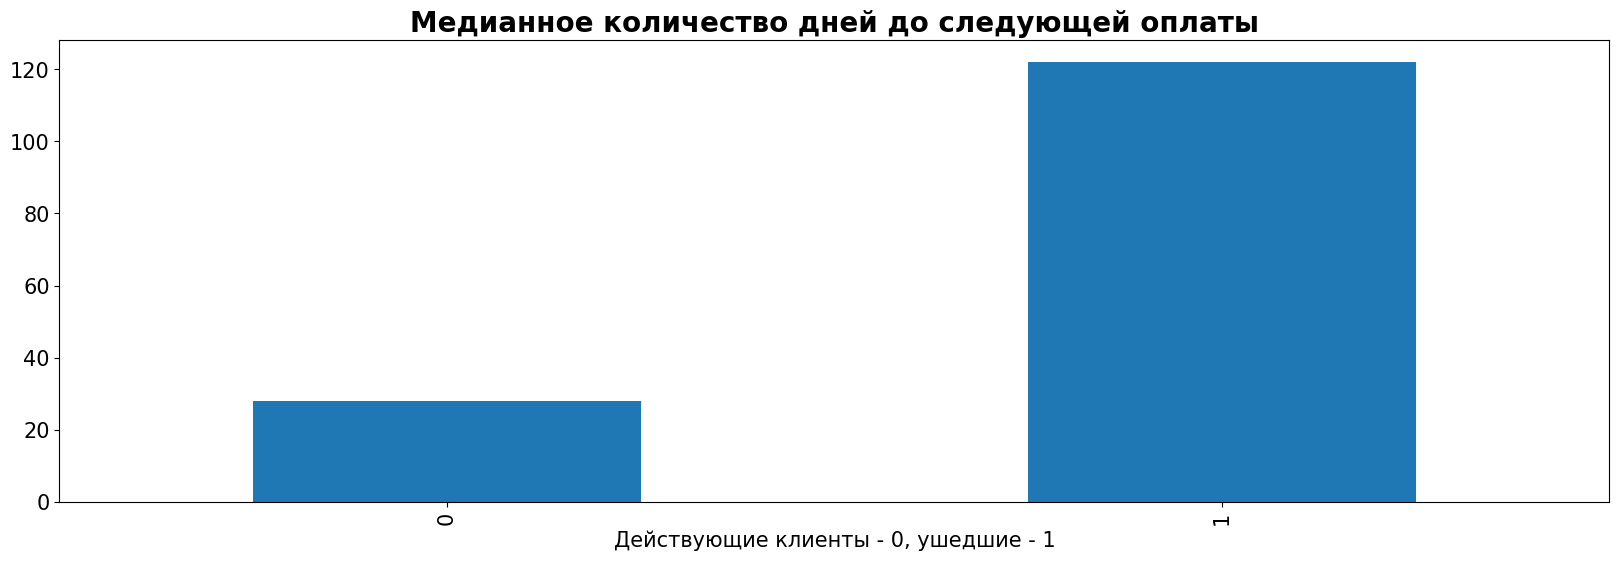

In [29]:
data_to_display = df.groupby('target')['days_till_next_payment'].median()
fig, ax = plt.subplots(figsize = (20, 6))
data_to_display.plot(kind='bar', ax=ax)
ax.set_title(f'Медианное количество дней до следующей оплаты', fontsize=20, weight='bold')
ax.set_ylabel('', fontsize=15)
ax.set_xlabel('Действующие клиенты - 0, ушедшие - 1', fontsize=15)
ax.tick_params(axis='both', labelsize=15)
plt.show()

Контринтуитивный результат. По какой-то причине у ушедших клиентов медианный предоплаченный период сильно больше.

Посмотрим как распределены периоды предоплаты для ушедших и оставшихся клиентов:

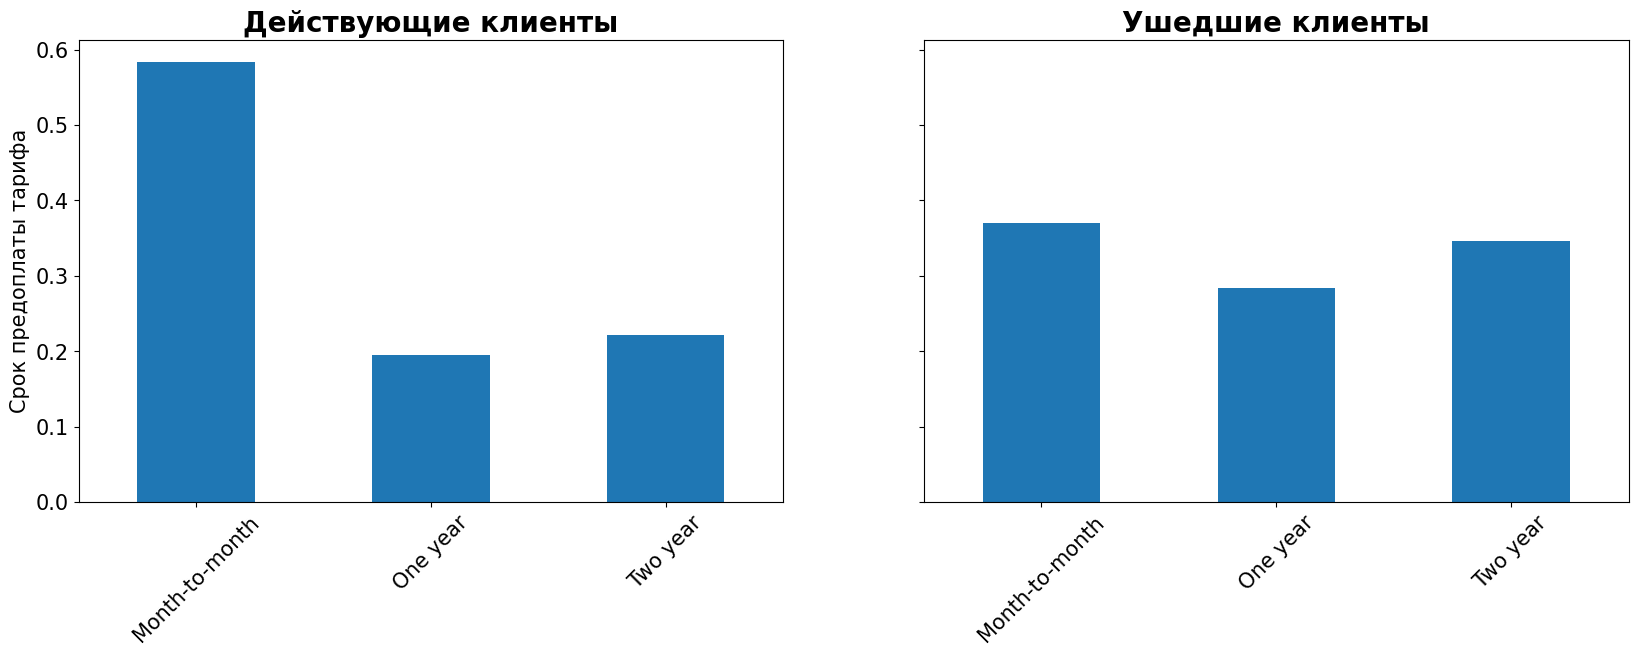

In [30]:
df.groupby(['target', 'type']).count()['gender']

data_to_display_1 = df[df['target'] == 0]['type'].value_counts(normalize=True).sort_index()
data_to_display_2 = df[df['target'] == 1]['type'].value_counts(normalize=True).sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 6), sharey=True)

data_to_display_1.plot(kind='bar', ax=ax1)
data_to_display_2.plot(kind='bar', ax=ax2)
ax1.set_title(f'Действующие клиенты', fontsize=20, weight='bold')
ax1.set_ylabel('Срок предоплаты тарифа', fontsize=15)
ax1.tick_params(axis='both', labelsize=15)
ax1.tick_params(axis='x', labelrotation=45)

ax2.set_title(f'Ушедшие клиенты', fontsize=20, weight='bold')
ax2.set_ylabel('Срок предоплаты тарифа', fontsize=15)
ax2.tick_params(axis='both', labelsize=15)
ax2.tick_params(axis='x', labelrotation=45)

plt.show()

По какой-то причине среди действующих клиентов наиболее популярна помесячная оплата. Вероятно долгосрочные тарифы имеют какие-то существенные недостатки.

После объединения таблиц мы видим ряд пропусков. Почти наверняка эти пропуски связаны с тем, что определенные пользователи пользуются или не пользуются теми или иными услугами, поэтому их нет, скажем, в таблице internet или phone. Сразу заполним эти пропуски заглушкой 'no service':

In [31]:
list_of_columns = ['internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines']
for column in list_of_columns:
    df[column].fillna('no service', inplace=True)

От греха подальше удалим все date столбцы:

In [32]:
df.drop(columns=['begin_date', 'end_date', 'current_date'], inplace=True)

Проверим гипотезу о том, что в итоге каждый пользователь какой-то услугой да пользовался:

In [33]:
df[(df['internet_service'] == 'no service') & (df['multiple_lines'] == 'no service')].shape[0]

0

Посмотрим на распределение услуг среди пользователей и добавим этот показатель как фичу:

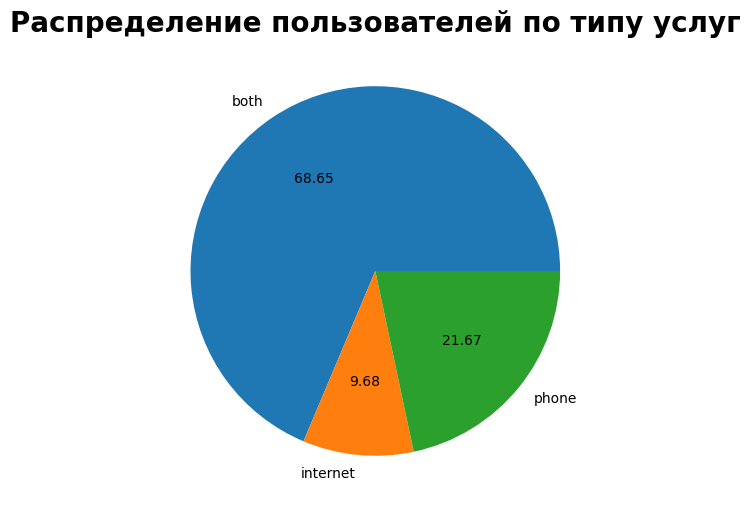

In [34]:
def func(x):
    if (x['internet_service'] != 'no service') and (x['multiple_lines'] != 'no service'):
        return 'both'
    elif x['internet_service'] == 'no service':
        return 'phone'
    else:
        return 'internet'

df['service_type'] = df.apply(func, axis='columns')
data_to_display = df.groupby(['service_type']).count()['type']

fig, ax = plt.subplots(figsize = (20, 6))
data_to_display.plot(kind='pie', ax=ax, autopct='%.2f')
ax.set_title(f'Распределение пользователей по типу услуг', fontsize=20, weight='bold')
ax.set_ylabel('', fontsize=15)
ax.tick_params(axis='both', labelsize=15)
plt.show()

Более 2/3 пользователей используют и интернет и телефонию.

Посмотрим каким методом оплаты пользуются пенсионеры и не пенсионеры:

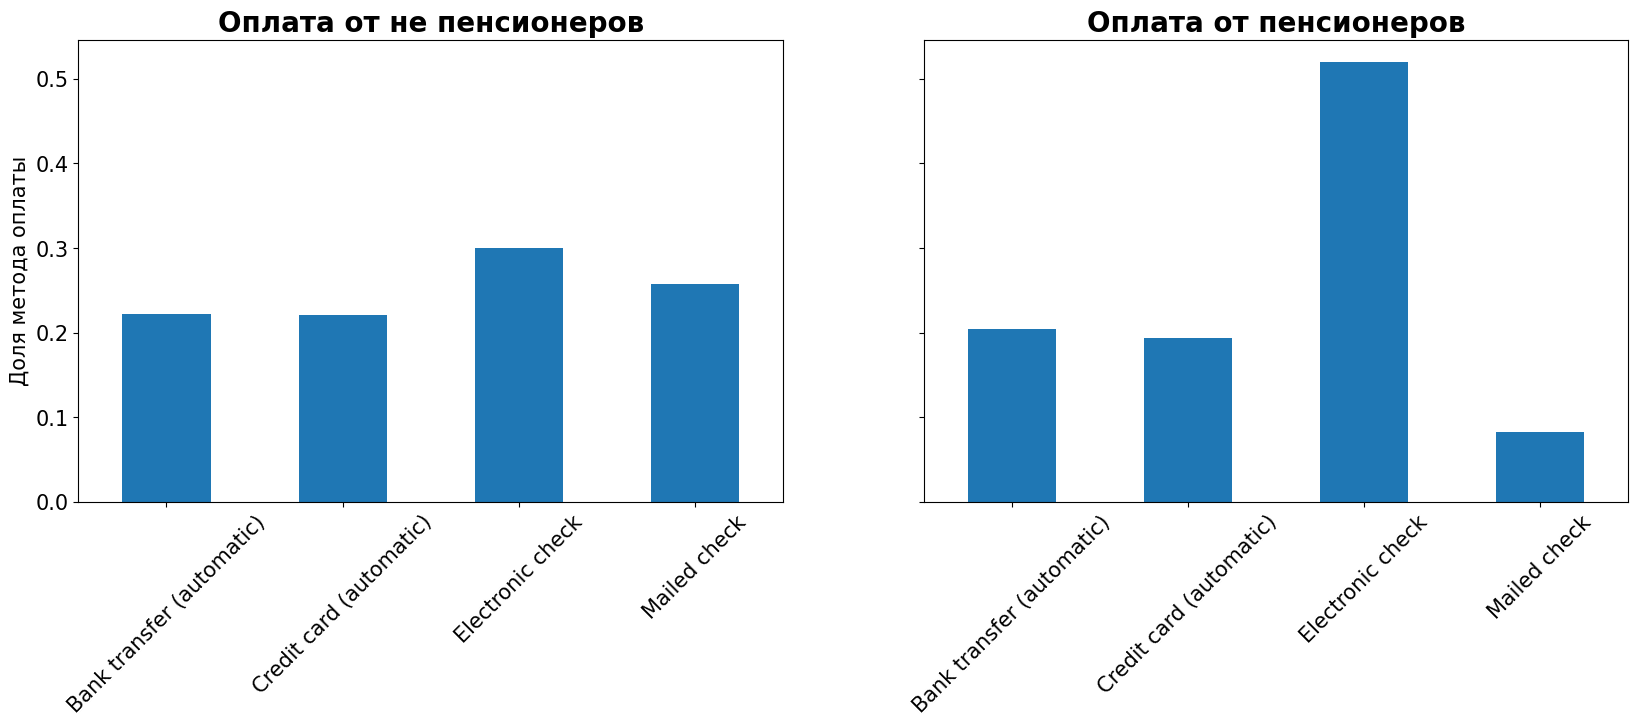

In [35]:
data_to_display_1 = df[df['senior_citizen'] == 0]['payment_method'].value_counts(normalize=True).sort_index()
data_to_display_2 = df[df['senior_citizen'] == 1]['payment_method'].value_counts(normalize=True).sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 6), sharey=True)

data_to_display_1.plot(kind='bar', ax=ax1)
data_to_display_2.plot(kind='bar', ax=ax2)
ax1.set_title(f'Оплата от не пенсионеров', fontsize=20, weight='bold')
ax1.set_ylabel('Доля метода оплаты', fontsize=15)
ax1.tick_params(axis='both', labelsize=15)
ax1.tick_params(axis='x', labelrotation=45)

ax2.set_title(f'Оплата от пенсионеров', fontsize=20, weight='bold')
ax2.set_ylabel('Доля метода оплаты', fontsize=15)
ax2.tick_params(axis='both', labelsize=15)
ax2.tick_params(axis='x', labelrotation=45)

plt.show()

Контринтуитивный результат, среди пенсионеров оплата электронным чеком пользуется особой популярностью, при этом бумажными чеками пенсионеры почти не пользуются.

У нас осталось всего несколько числовых столбцов. Нарисуем матрицу корреляций:

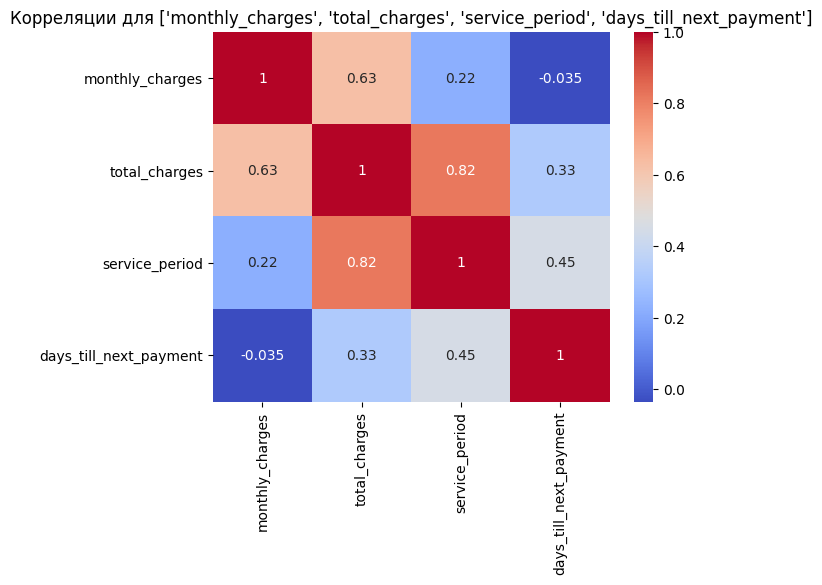

In [36]:
columns_for_corr = df.select_dtypes(include=['float64']).columns.to_list()
columns_for_corr.append('service_period')
columns_for_corr.append('days_till_next_payment')
fig, ax = plt.subplots()
ax.set_title(f'Корреляции для {columns_for_corr}')
dataplot = sns.heatmap(df[columns_for_corr].corr(), annot=True, cmap='coolwarm')
plt.show()

Посмотим на аналогичные матрицы для действующих и ушедших клиентов:

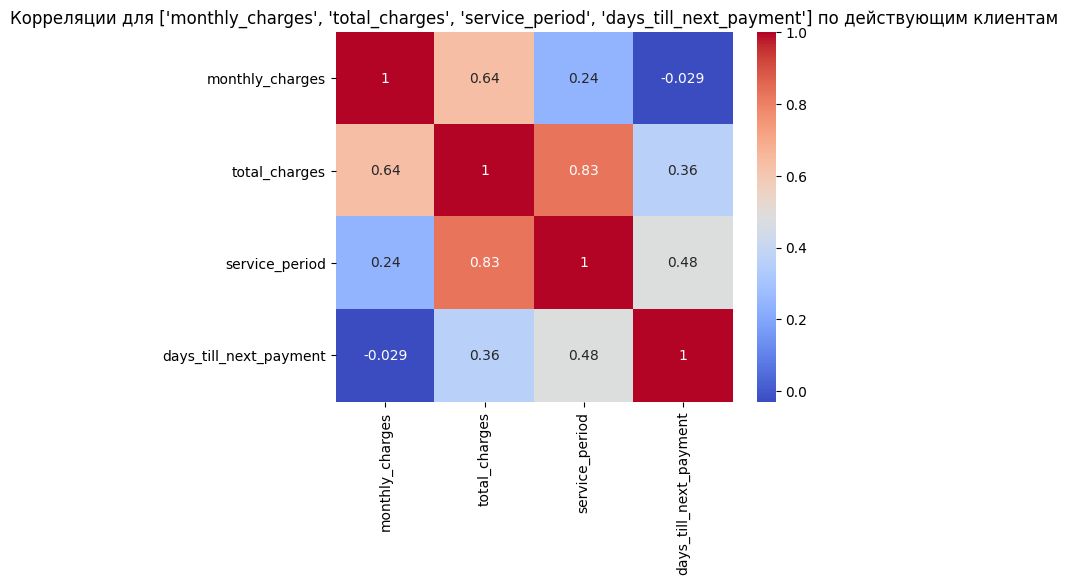

In [37]:
columns_for_corr = df.select_dtypes(include=['float64']).columns.to_list()
columns_for_corr.append('service_period')
columns_for_corr.append('days_till_next_payment')
fig, ax = plt.subplots()
ax.set_title(f'Корреляции для {columns_for_corr} по действующим клиентам')
dataplot = sns.heatmap(df[df['target'] == 0][columns_for_corr].corr(), annot=True, cmap='coolwarm')
plt.show()

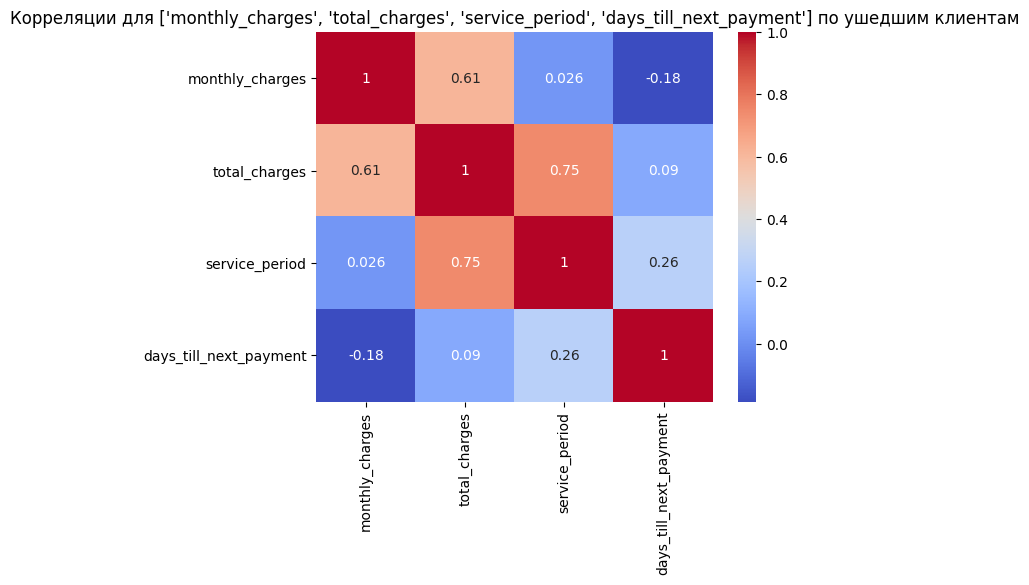

In [38]:
columns_for_corr = df.select_dtypes(include=['float64']).columns.to_list()
columns_for_corr.append('service_period')
columns_for_corr.append('days_till_next_payment')
fig, ax = plt.subplots()
ax.set_title(f'Корреляции для {columns_for_corr} по ушедшим клиентам')
dataplot = sns.heatmap(df[df['target'] == 1][columns_for_corr].corr(), annot=True, cmap='coolwarm')
plt.show()

Посмотрим на балланс классов в таргете:

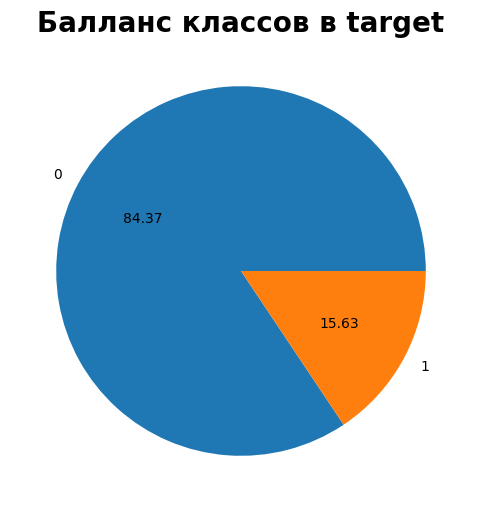

In [39]:
fig, ax = plt.subplots(figsize = (20, 6))
df['target'].value_counts(normalize=True).plot(kind='pie', ax=ax, autopct='%.2f')
ax.set_title('Балланс классов в target', fontsize=20, weight='bold')
ax.set_ylabel('', fontsize=15)
ax.tick_params(axis='both', labelsize=15)
plt.show()

### Выводы
* В объединенных данных есть незначительное количество дубликатов. Вероятнее всего - это совпадение (в основном категориальные данные, тарифные планы имеют часто фиксированную стоимость).
* Создан таргет на основе столбца `end_date`. Создан признак количества дней обслуживания. Столбцы с датами для предотвращения утечки данных удалены.
* Среди ушедших клиентов повышенное количество клиентов, которые проплатили длительный период на будущее. **Вероятно есть какая-то проблема с долгосрочными тарифами.**
* Большая часть пользователей пользуется как услугами интернета, так и телефонии.
* Самый популярный способ оплаты - electronic check, причем среди пенсионеров этот способ оплаты пользуется особой популярностью.
* В данных для дальнейшего анализа остались только 4 числовых признака. Уровень корреляции между ежемесячными платежами и суммарными составляет 63%. Уровень корреляции между суммарными платежами и периодом обслуживания ожидаемо высокий - 82%. Остальные корреляции менее 50%. Расчёт корреляций по группам оставшихся и ушедхих клиентов сильно картину не меняет.
* Классы разбалансированы, положительных семплов около 15%.

## Подготовка данных
**Подготовка данных для обучения модели. Выделение выборок для обучения, кроссвалидации и тестировния.**


Разделим выборку на тренировочную и тестовую:

In [40]:
X = df.drop(columns=['target'])
y = df['target']
df.shape, X.shape, y.shape

((7043, 21), (7043, 20), (7043,))

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=random_state,
                                                    shuffle=True,
                                                    stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5282, 20), (1761, 20), (5282,), (1761,))

Взглянем на результат:

In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 8314-HTWVE to 9955-QOPOY
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   type                    5282 non-null   object 
 1   paperless_billing       5282 non-null   object 
 2   payment_method          5282 non-null   object 
 3   monthly_charges         5282 non-null   float64
 4   total_charges           5282 non-null   float64
 5   gender                  5282 non-null   object 
 6   senior_citizen          5282 non-null   int64  
 7   partner                 5282 non-null   object 
 8   dependents              5282 non-null   object 
 9   internet_service        5282 non-null   object 
 10  online_security         5282 non-null   object 
 11  online_backup           5282 non-null   object 
 12  device_protection       5282 non-null   object 
 13  tech_support            5282 non-null   object 
 14  streaming_tv            5282 n

### Выводы
* Выделена тренировочная и тестовая выборки.
* Так как уникальных значений в категориальных столбцах не так много - решено сделать one-hot кодирование с drop_first, но сделано оно будет на этапе создания pipeline.


## Обучение моделей машинного обучения
**Обучение не менее двух типов моделей и подбор лучших гиперпараметров.**


Посмотрим на количество уникальных элементов в категориальных столбцах типа `object` (эти столбцы мы будем кодировать on-hot):

In [43]:
unique_in_categorical = df.describe(include='all').loc['unique', :].dropna()
features_to_oh = unique_in_categorical.index
unique_in_categorical

type                 3
paperless_billing    2
payment_method       4
gender               2
partner              2
dependents           2
internet_service     3
online_security      3
online_backup        3
device_protection    3
tech_support         3
streaming_tv         3
streaming_movies     3
multiple_lines       3
service_type         3
Name: unique, dtype: object

Протестируем три классификационных типа моделей: логистическая регрессия; случайный лес; легкую модель градиентного бустинга. На входе привёдем данные к одному масштабу и выберем лучшие параметры через стратифицированный kfold и рандомный CV search:

In [44]:
%%time
# Для будущих результатов
results = []

model_1 = LogisticRegression(random_state=random_state)
model_2 = RandomForestClassifier(random_state=random_state)
model_3 = LGBMClassifier(random_state=random_state)

# Для экономии времени ниже оставлены только лучшие параметры.
param_distribution_1 = {'model__C': randint(6, 7)
                        }

param_distribution_2 = {
                        'model__max_depth': randint(7, 8),
                        'model__n_estimators': randint(85, 86),
                        }

param_distribution_3 = {
                        'model__num_leaves': randint(40, 41),
                        'model__max_depth': randint(16, 17),
                        'model__min_data_in_leaf': randint(8, 9),
                        }


# Объединим в лист для перебора
models_and_distrs = [('LR', model_1, param_distribution_1),
                     ('RFC', model_2, param_distribution_2),
                     ('LGBMC', model_3, param_distribution_3),
                     ]

# Запустим подбор лучших параметров
for model_name, model, param_distribution in models_and_distrs:
    oh_encoder = OneHotEncoder(drop='if_binary',
                               handle_unknown='error')
    c_transformer = ColumnTransformer([('oh_encoder', oh_encoder, features_to_oh)],
                                      remainder='passthrough')

    pipe = Pipeline([('oh_encoder', c_transformer),
                     ('scaler', StandardScaler()),
                     ('model', model)])

    kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)
    cv = RandomizedSearchCV(estimator=pipe,
                            cv=kf,
                            scoring='roc_auc',
                            param_distributions=param_distribution,
                            n_jobs=-1,
                            n_iter=1,
                            verbose=0,
                            random_state=random_state,
                            )

    cv.fit(X_train, y_train)

    # Индекс лучшей модели
    best_index = cv.cv_results_["mean_test_score"].argmax()
    display(f'Лучший результат для {model_name}: {cv.best_params_}, {cv.best_score_:.2%}')
    display(f'Время обучения лучшей модели: {cv.cv_results_["mean_fit_time"][best_index]:.2f}')
    display(f'Время предсказания лучшей модели: {cv.cv_results_["mean_score_time"][best_index]:.2f}')

    # Добавление в результаты
    results.append((model_name,
                    cv.best_estimator_,
                    cv.best_params_,
                    cv.best_score_,
                    cv.cv_results_["mean_fit_time"][best_index],
                    cv.cv_results_["mean_score_time"][best_index],
                   ))


"Лучший результат для LR: {'model__C': 6}, 76.47%"

'Время обучения лучшей модели: 0.16'

'Время предсказания лучшей модели: 0.03'

"Лучший результат для RFC: {'model__max_depth': 7, 'model__n_estimators': 85}, 82.51%"

'Время обучения лучшей модели: 0.79'

'Время предсказания лучшей модели: 0.07'

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Number of positive: 826, number of negative: 4456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156380 -> initscore=-1.685412
[LightGBM] [Info] Start training from score -1.685412


"Лучший результат для LGBMC: {'model__max_depth': 16, 'model__min_data_in_leaf': 8, 'model__num_leaves': 40}, 88.05%"

'Время обучения лучшей модели: 1.07'

'Время предсказания лучшей модели: 0.05'

CPU times: total: 1.28 s
Wall time: 9.59 s


## Выбор лучшей модели
**Выбор лучшей модели и проверка на тестовой выборке.**


Визуализируем итоговые результаты подбора оптимальных гиперпараметров:

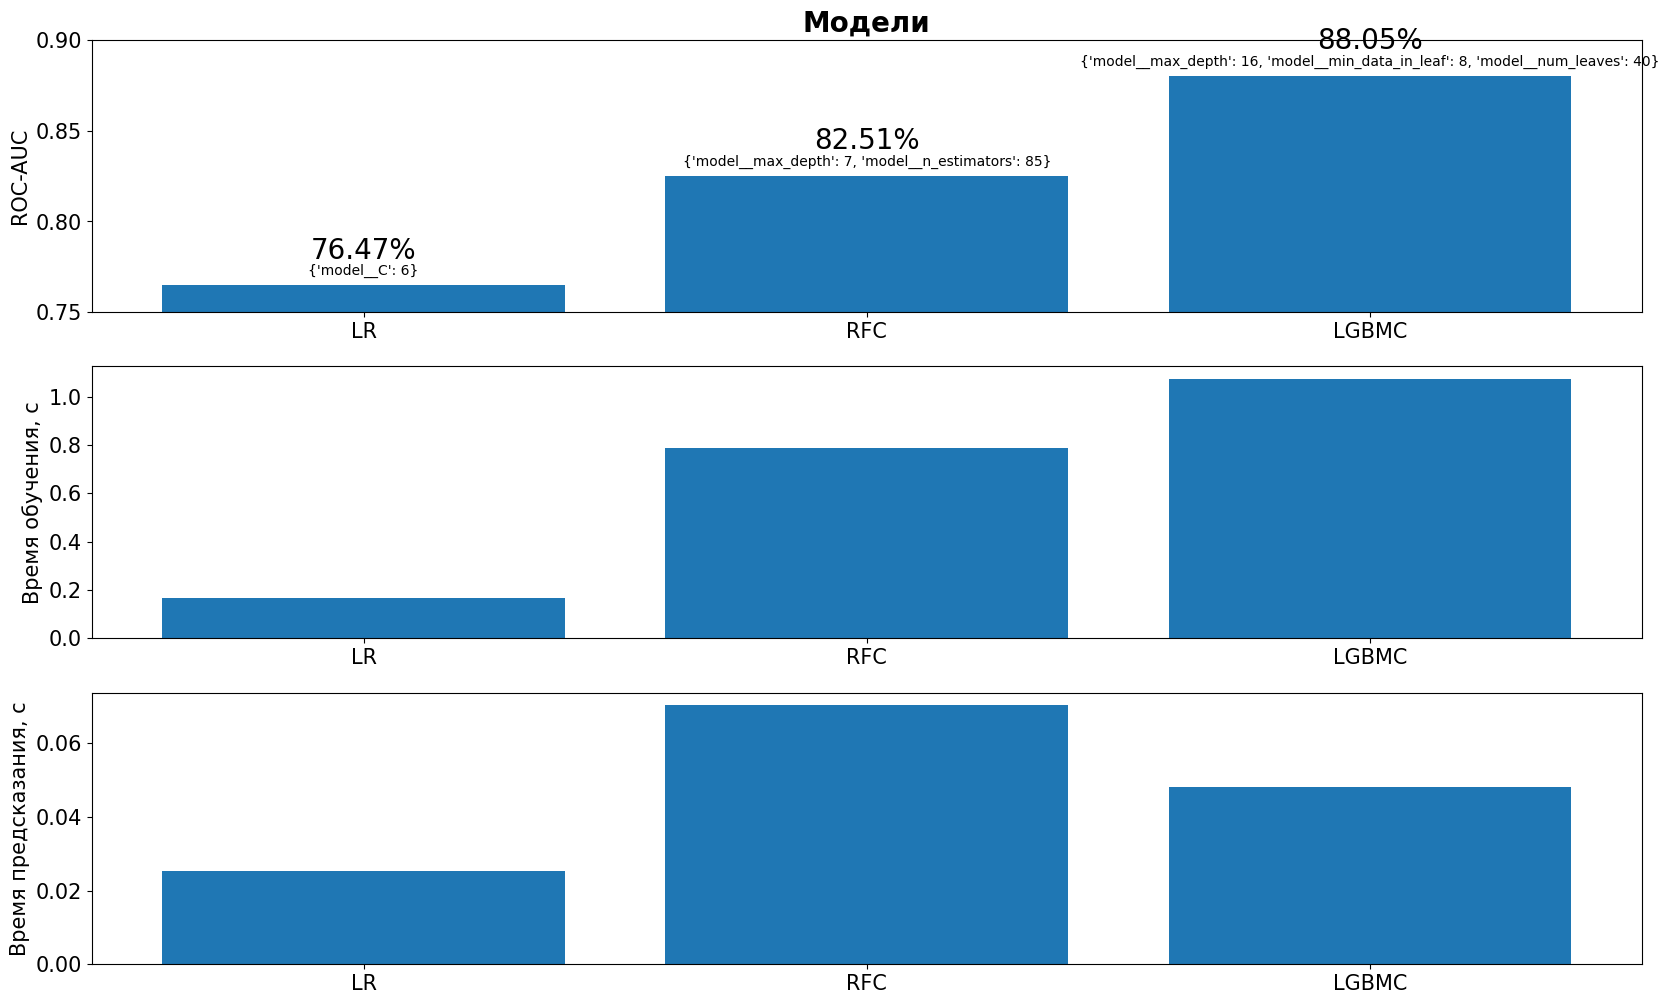

In [45]:
data_for_graph_best_params = {}
data_for_graph_score = {}
data_for_graph_fitting_time = {}
data_for_graph_prediction_time = {}

for result in results:
    data_for_graph_best_params[str(result[0])] = result[2]
    data_for_graph_score[str(result[0])] = result[3]
    data_for_graph_fitting_time[str(result[0])] = result[4]
    data_for_graph_prediction_time[str(result[0])] = result[5]

data_for_graph_score = pd.Series(data_for_graph_score)
data_for_graph_fitting_time = pd.Series(data_for_graph_fitting_time)
data_for_graph_prediction_time = pd.Series(data_for_graph_prediction_time)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 12))
ax1.set_title('Модели', fontsize=20, weight='bold')
ax1.set_ylabel('ROC-AUC', fontsize=15)
ax2.set_ylabel('Время обучения, с', fontsize=15)
ax3.set_ylabel('Время предсказания, с', fontsize=15)
ax1.set_ylim(0.75, 0.9)
ax1.tick_params(axis='both', labelsize=15)
ax2.tick_params(axis='both', labelsize=15)
ax3.tick_params(axis='both', labelsize=15)
ax1.bar(data_for_graph_score.index, data_for_graph_score.values)
ax2.bar(data_for_graph_fitting_time.index, data_for_graph_fitting_time.values)
ax3.bar(data_for_graph_prediction_time.index, data_for_graph_prediction_time.values)

for rect, params in zip(ax1.patches, data_for_graph_best_params.values()):
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = 5
        label = "{:.2%}".format(y_value)
        ax1.annotate(
            label,
            (x_value, y_value),
            xytext=(0, space + 10),
            textcoords="offset points",
            ha='center',
            va='bottom',
            fontsize=20)
        ax1.annotate(
            params,
            (x_value, y_value),
            xytext=(0, space),
            textcoords="offset points",
            ha='center',
            va='bottom',
            fontsize=10)

plt.show();

Проведем выбор лучшей модели по основному параметру (ROC-AUC):

In [46]:
best_model_name = None
best_model = None
best_params = None
best_result = -float('inf')

for result in results:
    if result[3] > best_result:
        best_model_name = result[0]
        best_model = result[1]
        best_params = result[2]
        best_result = result[3]

display(f'Лучшая модель: {best_model_name}, {best_params}')
display(f'ROC-AUC лучшей модели: {best_result:0.2%}')

"Лучшая модель: LGBMC, {'model__max_depth': 16, 'model__min_data_in_leaf': 8, 'model__num_leaves': 40}"

'ROC-AUC лучшей модели: 88.05%'

Проверим результаты работы выбранной модели на тестовых данных:

In [47]:
pipe = best_model
set_config(display="diagram")
pipe

Pipeline(steps=[('oh_encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oh_encoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['type', 'paperless_billing', 'payment_method', 'gender', 'partner',
       'dependents', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines', 'service_type'],
      dtype='object'))])),
                ('scaler', StandardScaler()),
                ('model',
                 LGBMClassifier(max_depth=16, min_data_in_leaf=8, num_leaves=40,
                                random_state=160224))])

In [48]:
%%time
# Запускаем обучение
pipe.fit(X_train, y_train);

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Number of positive: 826, number of negative: 4456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156380 -> initscore=-1.685412
[LightGBM] [Info] Start training from score -1.685412
CPU times: total: 516 ms
Wall time: 296 ms


Сделаем расчёт предсказания:

In [49]:
%%time
y_predicted_proba = pipe.predict_proba(X_test)
y_predicted_proba = [x[1] for x in y_predicted_proba]

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
CPU times: total: 62.5 ms
Wall time: 42 ms


Посчитаем итоговую оценку:

In [50]:
auc_roc_score = roc_auc_score(y_test, y_predicted_proba)
display(f'Итоговый AUC-ROC на тестовых данных: {auc_roc_score:.2%}')

'Итоговый AUC-ROC на тестовых данных: 92.06%'

**Результат достигнут.**

Построим график зависимости precission, recall и f1_score в зависимости от threshold:

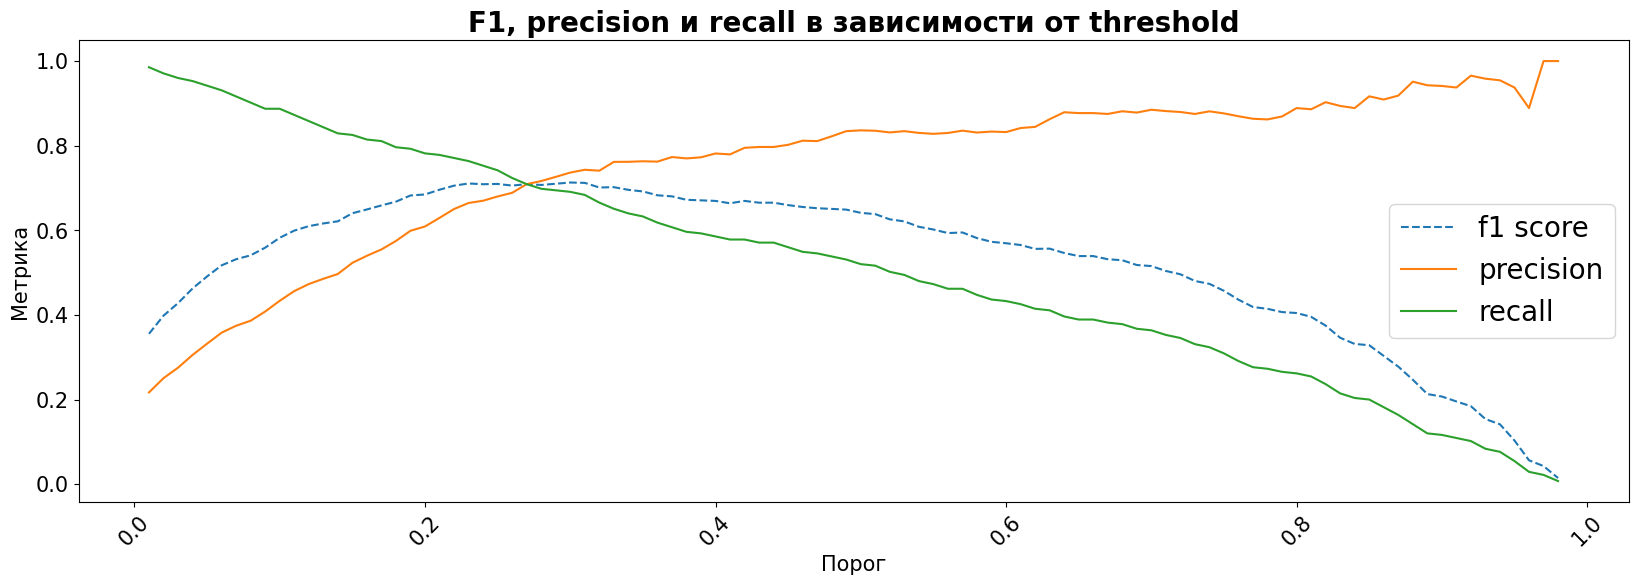

In [51]:
metrics = {}
point_number = 100
for i in range(1, point_number-1):
    threshold = i / point_number
    y_predicted = [0 if x < threshold else 1 for x in y_predicted_proba]
    f1 = f1_score(y_test, y_predicted)
    p = precision_score(y_test, y_predicted)
    r = recall_score(y_test, y_predicted)
    tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
    metrics[threshold] = (f1, p, r, tn, fp, fn, tp)

metrics = pd.DataFrame(metrics).transpose()
metrics.columns = ['f1', 'p', 'r', 'tn', 'fp', 'fn', 'tp']

fig, ax = plt.subplots(figsize = (20, 6))

metrics['f1'].plot(kind='line', ax=ax, legend='f1', style='--')
metrics['p'].plot(kind='line', ax=ax, legend='precision')
metrics['r'].plot(kind='line', ax=ax, legend='recall')
ax.set_title(f'F1, precision и recall в зависимости от threshold', fontsize=20, weight='bold')
ax.set_ylabel('Метрика', fontsize=15)
ax.set_xlabel('Порог', fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.tick_params(axis='x', labelrotation=45)
plt.legend(prop={'size': 20}, labels=['f1 score', 'precision', 'recall'])
plt.show();

Посмотрим на некоторые отдельные точки графика:

In [52]:
metrics[(metrics['f1'] == metrics['f1'].max())
        | ((metrics['p'] > 0.89)
        & (metrics['p'] < 0.90))
        | ((metrics['r']>0.89)
        & (metrics['r']<0.91))]

,f1,p,r,tn,fp,fn,tp
0.08,0.54,0.39,0.90,1092.00,394.00,27.00,248.00
0.30,0.71,0.74,0.69,1418.00,68.00,85.00,190.00
0.83,0.35,0.89,0.21,1479.00,7.00,216.00,59.00


Получим из модели итоговый список признаков и приведём его в понятный вид:

In [53]:
feature_names = pipe['oh_encoder'].get_feature_names()

for i, name in enumerate(feature_names):
    num = ''.join(re.findall('[0-9]',name))
    try:
        num = int(num)
        pos_to_cut = feature_names[i].find('_', 12)
        feature_names[i] = features_to_oh[num] + feature_names[i][pos_to_cut:]
    except:
        pass

display(f'Итоговое количество признаков: {len(feature_names)}')

'Итоговое количество признаков: 43'

In [54]:
feature_names

['type_Month-to-month',
 'type_One year',
 'type_Two year',
 'paperless_billing_Yes',
 'payment_method_Bank transfer (automatic)',
 'payment_method_Credit card (automatic)',
 'payment_method_Electronic check',
 'payment_method_Mailed check',
 'gender_Male',
 'partner_Yes',
 'dependents_Yes',
 'internet_service_DSL',
 'internet_service_Fiber optic',
 'internet_service_no service',
 'online_security_No',
 'online_security_Yes',
 'online_security_no service',
 'online_backup_No',
 'online_backup_Yes',
 'online_backup_no service',
 'device_protection_No',
 'device_protection_Yes',
 'device_protection_no service',
 'tech_support_No',
 'tech_support_Yes',
 'tech_support_no service',
 'streaming_tv_No',
 'streaming_tv_Yes',
 'streaming_tv_no service',
 'streaming_movies_No',
 'streaming_movies_Yes',
 'streaming_movies_no service',
 'multiple_lines_No',
 'multiple_lines_Yes',
 'multiple_lines_no service',
 'service_type_both',
 'service_type_internet',
 'service_type_phone',
 'monthly_charges'

Посмотрим на важность признаков:

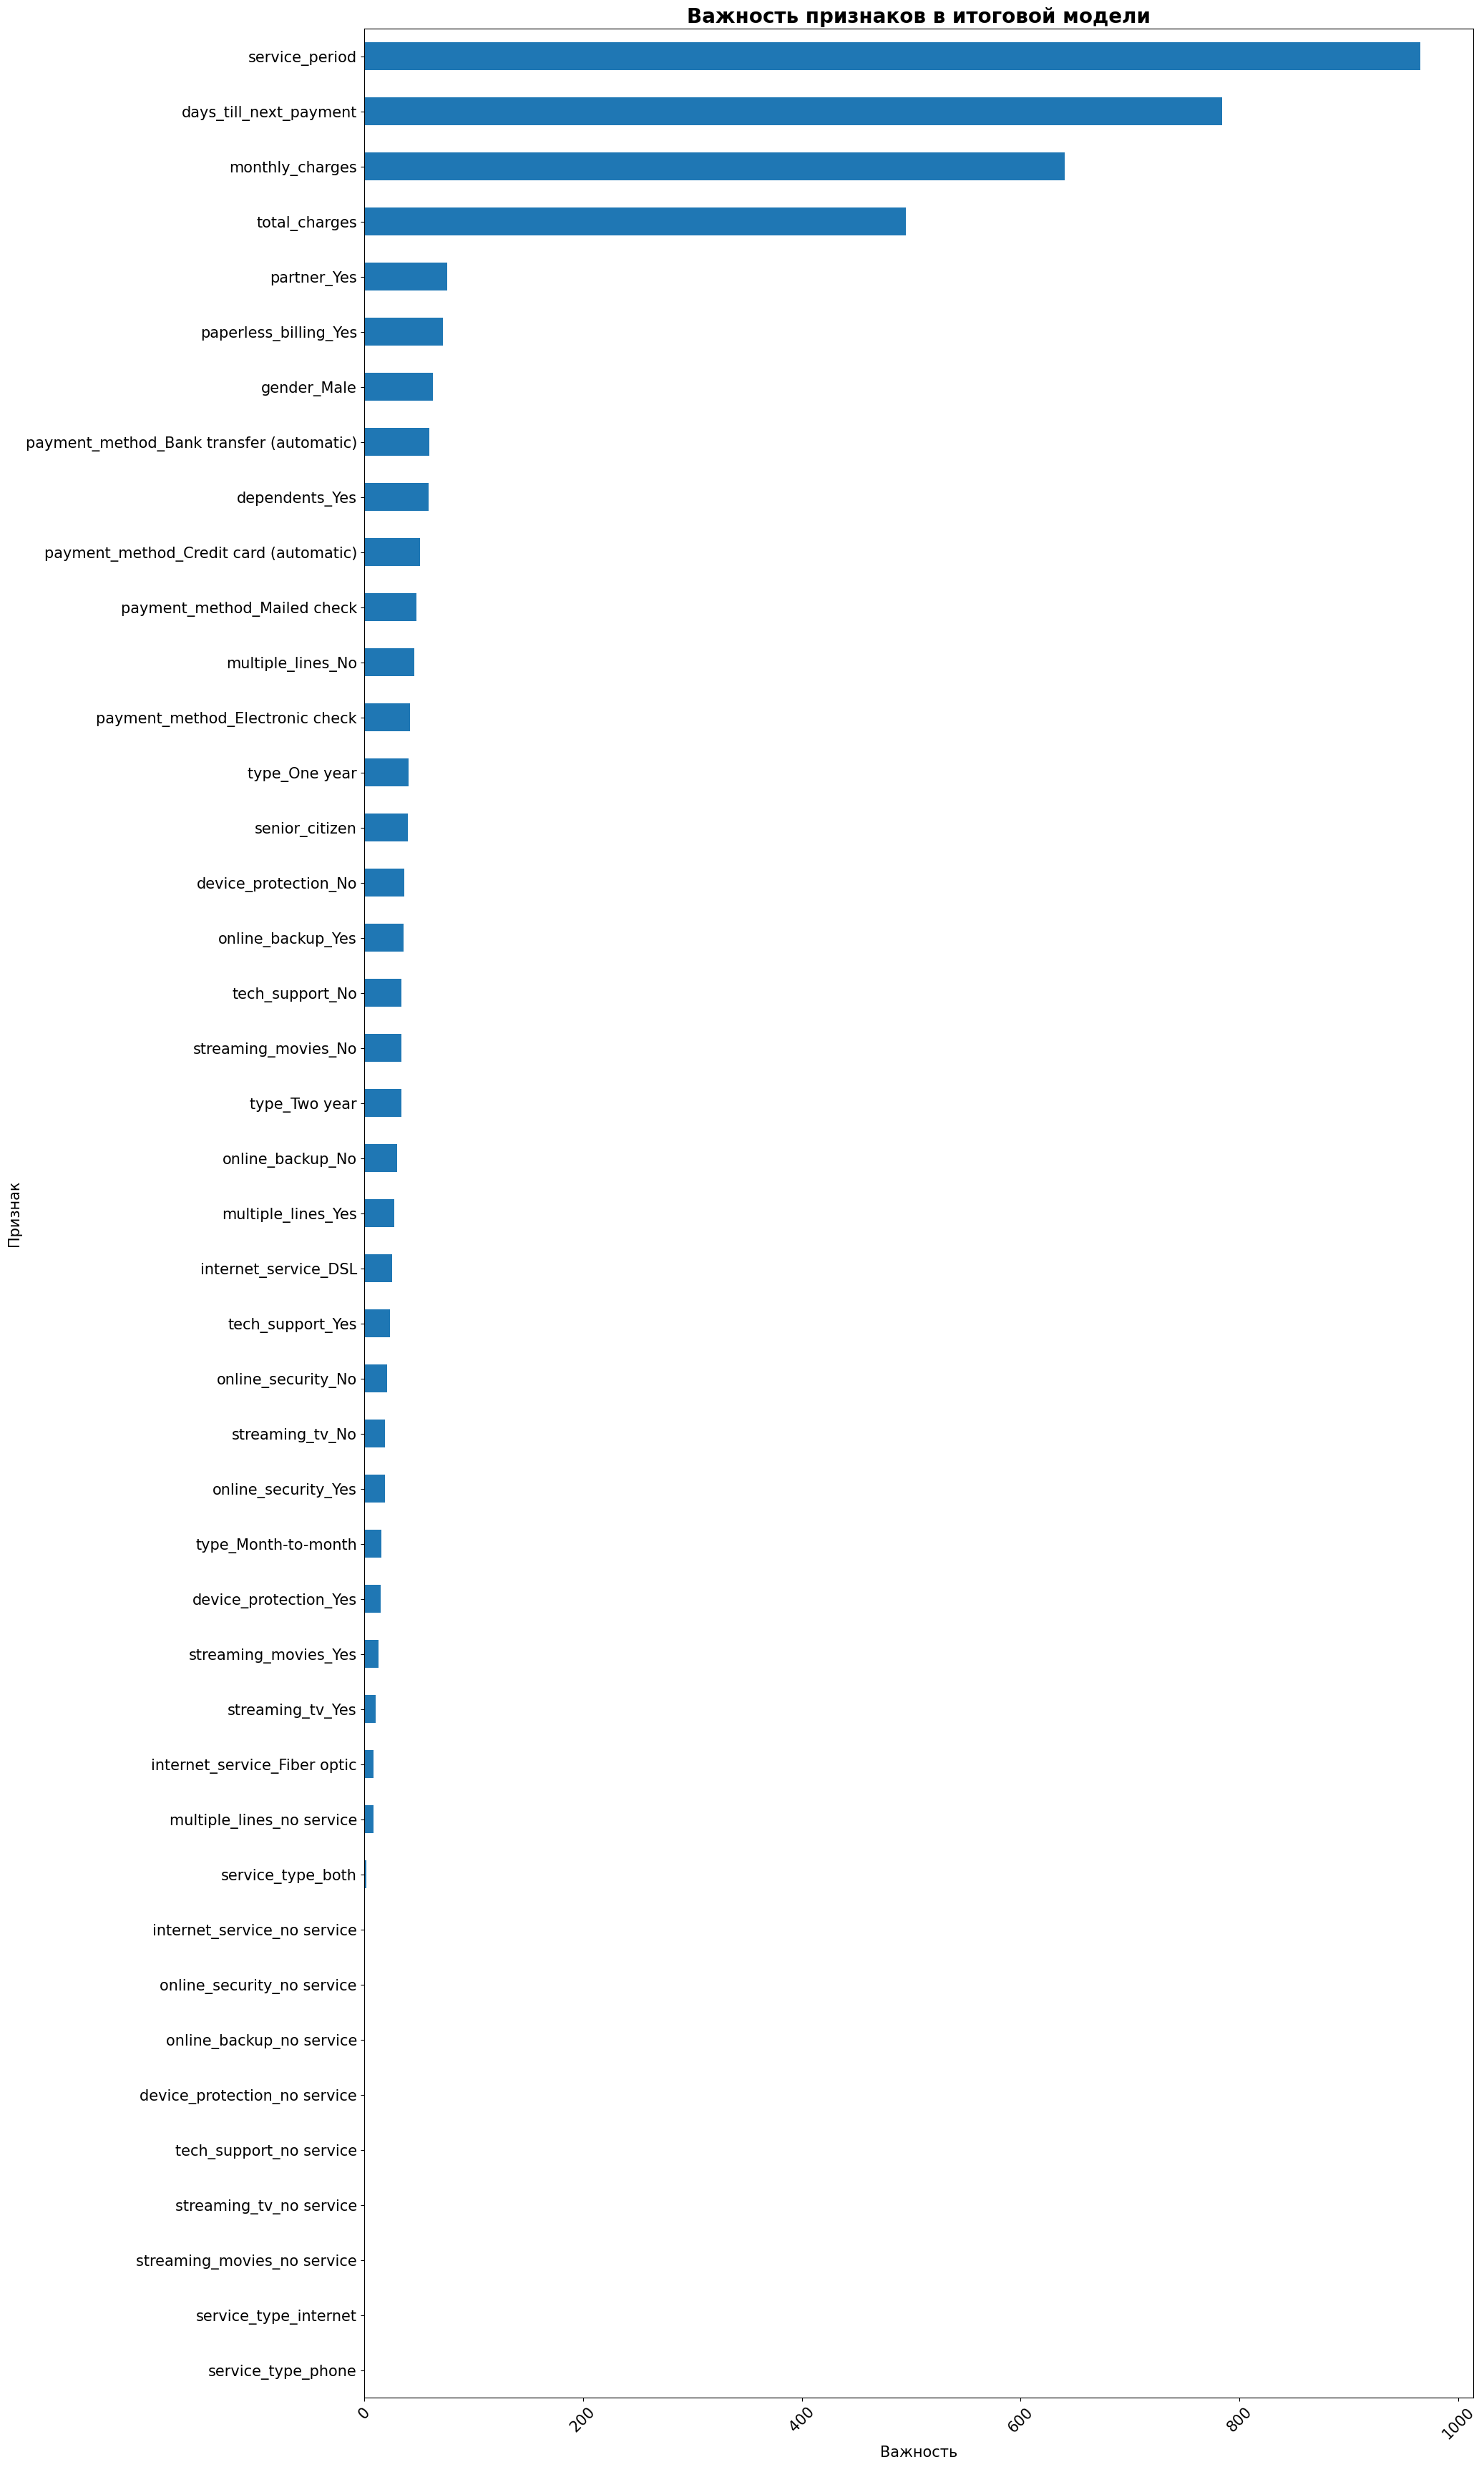

In [55]:
feature_importance = pd.Series(pipe['model'].feature_importances_, feature_names).sort_values(ascending=True)

fig, ax = plt.subplots(figsize = (20, len(feature_names)))
feature_importance.plot(kind='barh', ax=ax)
ax.set_title(f'Важность признаков в итоговой модели', fontsize=20, weight='bold')
ax.set_ylabel('Признак', fontsize=15)
ax.set_xlabel('Важность', fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.tick_params(axis='x', labelrotation=45)
plt.show();

### Выводы
В результате из рассматриваемых моделей выбрана лучшей LGBMClassifier с параметрами max_depth=16, min_data_in_leaf=8, num_leaves=40.

На тестовой выборке достигнут результат 92.06% по ROC-AUC.

В зависимости от конкретных задач и возможностей клиент может применить разное пороговое значения для принятия решений. Если маркетинговый бюджет невелик, то лучше стремиться к высокой precision, тогда модель будет выделять клиентов, которые с набольшей вероятностью собираются прекратить использование услуг. И наоборот, для максимального охвата при больших возможностях по маркетингу можно ориентироваться на большой recall.

Точками для ориентирования являются:
* Порог на уровне ~8% даст recall около 90%
* Порог на уровне ~83% даст precision около 90%
* Сбалансированный вариант по f1 находится около порога в 30%.

Важность признаков:
* Итоговое количество признаков 43 + таргет.
* Лидерами по важности являются период обслуживания клиента, количество дней до следуюшего платежа, ежемесячный платёж и суммарные расходы клиента.
* Среди прочих признаков можно выделить ряд персональных (умеренная важность), таких как половую принадлежность, наличие детей, супруги. Так же умеренную важность показали использование электронных рассчётных листов, использование автоматических банковских переводов. Остальные признаки имеют меньшую важность.
* 10 признаков (3 добавленных + 7 содержащие информацию о том, чем клиент не пользуется) имеют нулевую важность. Эти признаки можно оптимизировать, но это останется за пределами данной работы.

## Общие выводы и рекомендации заказчику
**Выводы по полученным результатам и рекомендации для бизнеса.**

* Загружены и проанализированы данные по более 7000 клиентов оператора связи в период с октября 2013 года по февраль 2020 года. Данные относительно чистые, пропусков нет, выбросов нет, дубли встречаются очень редко и скорее всего являются результатом совпадения, распределения преимущественно имеют объяснимый характер.
* Данные обработаны, приведены к единому типу и объединены в единый датафрейм для дальнейшего изучения.
* По всем данным проведен исследовательский анализ, выявлен ряд важных для задачи взаимосвязей. Вручную добавлено несколько признаков, которые гипотетически могут оказать влияние на качество обучения, а так же на основе дат добавлен target. Анализ target столбца показывает разбалансированность целевого показателя (позитивных примеров около 15%).
* Проведен анализ корреляций для числовых признаков.
* При подготовке данных для обучения приняты меры по предотвращению утечки данных.
* Данные подготовлены к обучению с использованием one-hot кодирования.
* Исследованы три типа моделей (LR, RFC, LGBMC), к каждой из которых подобраны оптимальные гиперпараметры. Лучший результат по основной метрике ROC-AUC показала модель LGBMClassifier с параметрами max_depth=16, min_data_in_leaf=8, num_leaves=40.
* **Итоговая модель протестирована на тестовых данных, достигнут целевой результат.**
* Обозначены ориентиры по threshold для практического применения.
* Проведен анализ важности признаков.

**Рекомендации для бизнеса:**
* Провести верхнеуровневую проверку данных в таблицах peronal и internet на предмет дубликатов? Не является ли большое количество дублей результатом какой-то ошибки?
* Выяснить объясним ли пик по количеству привлечённых клиентов в феврале 2014 года. Не является ли это ошибкой?
* Организовать сбор данных, связанных с датами регистрации и ухода клиента без округлений до месяца, что скорее всего увеличит точность модели, т.к. 2 из 4 признаков из топа по значимости связаны с датами.
* Практически использовать результаты анализа по пороговому значению для подбора оптимального значения и оценки финансового эффекта от планируемых мероприятий.